# https://medium.com/analytics-vidhya/google-play-store-apps-reviews-scraping-and-text-analytics-sentiment-analysis-5303294fffa7

# I Analyse de données

In [ ]:
# Téléchargement des packages
!pip install google_play_scraper
!pip install -q -U watermark
!pip install -qq transformers
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 114.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.4 MB/s eta 0:00:00
2023-10-25 21:09:16.743040: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 21:09:16.743102: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 21:09:16.743148: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] U

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.1.0+cu118
transformers: 4.34.1



In [ ]:
# Importation des packages

from wordcloud import WordCloud, STOPWORDS
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import datetime
import seaborn as sns
from datetime import date
from datetime import datetime
from google_play_scraper import app, Sort, reviews_all, reviews
import string
import re
from pprint import pprint
import tqdm
import pickle
import os
from PIL import Image
import nltk
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import *
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#FFAEB9", "#FF1493", "#FFC125", "#8B4789", "#90EE90", "#000080"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


device(type='cuda', index=0)

In [ ]:
# Importation des commentaires du Crédit Agricole

ca = reviews_all(
    'fr.creditagricole.androidapp', # 2000 commentaires
    sleep_milliseconds=0,
    lang ='en',
    country ='us',
    sort = Sort.NEWEST)

In [ ]:
# Visualisation du dataframe du Crédit Agricole nommé 'df'

df = pd.DataFrame(np.array(ca), columns=["review"])
df = df.join(pd.DataFrame(df.pop('review').tolist()))
df.head()

reviewId                          userName  \
0  7a8ae8ca-f2ad-4624-90f1-72f928e8d080                       Jules Azman   
1  f93249e2-0396-41dd-a532-2a3b999e8aea                   Roselyne Petrus   
2  51cdc82f-460b-4289-ab3e-3c6db93cfc4e                    Mickael Dijoux   
3  af0bb9d2-1449-4f80-ae18-8b179523c293  Matthew “daoctopuss” Bartholomew   
4  67b87068-ddc3-4ce9-8b3e-a3060164e260                      Brice Dumont   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a/ACg8oc...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a/ACg8oc...   

                                             content  score  thumbsUpCount  \
0  La nouvelle version de l'application est bien ...      3              3   
1      Horrible !!!!! Returned a l'ancien programme.      1              0   
2  Points négatifs : La gestion des virements par...      1              0   
3  Appli géniale. Et l'équipe derrière est incroy...      5              0   
4  Appli prototype Elle ne sert à rien. ( sauf co...      1              0   

  reviewCreatedVersion                  at replyContent repliedAt appVersion  
0              31.11.0 2023-10-10 10:30:00         None       NaT    31.11.0  
1              31.10.0 2023-09-16 19:26:22         None       NaT    31.10.0  
2                 None 2023-09-13 05:00:39         None       NaT       None  
3              31.10.0 2023-09-12 13:18:26         None       NaT    31.10.0  
4               31.8.0 2023-08-29 09:42:47         None       NaT     31.8.0

In [ ]:
# Importation des commentaires de BNP Paribas

bp = reviews_all(
    'net.bnpparibas.mescomptes', # 1064 commentaires
    sleep_milliseconds=0,
    lang ='en',
    country ='us',
    sort = Sort.NEWEST)

In [ ]:
# Visualisation du dataframe de BNP Paribas nommé 'data'

data = pd.DataFrame(np.array(bp), columns=["review"])
data = data.join(pd.DataFrame(data.pop('review').tolist()))
data.tail()

reviewId       userName  \
1075  e88bdeaf-0c38-45a2-b3ac-1309020eefa8  A Google user   
1076  b771552a-4dfa-4fed-b3fa-433acd0c109c  A Google user   
1077  fa6fceef-9116-4d88-a910-5d3afa765cda  A Google user   
1078  29bce01a-7a0e-47d2-87a9-3c3dedaa085c  A Google user   
1079  5280689d-77a1-4725-9fdb-cd27661fb321  A Google user   

                                              userImage  \
1075  https://play-lh.googleusercontent.com/EGemoI2N...   
1076  https://play-lh.googleusercontent.com/EGemoI2N...   
1077  https://play-lh.googleusercontent.com/EGemoI2N...   
1078  https://play-lh.googleusercontent.com/EGemoI2N...   
1079  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                content  score  thumbsUpCount  \
1075                           Please put it on SD card      4              0   
1076                                  C super...love it      5              0   
1077                                             Genial      5              0   
1078  Bonne application, très utile. Marche bien dan...      5              1   
1079  Thanks for this so practical app.hand,useful n...      5              1   

     reviewCreatedVersion                  at replyContent repliedAt  \
1075                  1.0 2011-02-15 19:16:41         None       NaT   
1076                  1.0 2010-10-01 17:07:23         None       NaT   
1077                  1.0 2010-09-24 07:42:57         None       NaT   
1078                  1.0 2010-09-18 20:47:45         None       NaT   
1079                  1.0 2010-09-05 07:00:00         None       NaT   

     appVersion  
1075        1.0  
1076        1.0  
1077        1.0  
1078        1.0  
1079        1.0

In [ ]:
# Création d'un ID pour chaque commentaire
df['ID'] = range(1,len(df)+1)
data['ID'] = range(1,len(data)+1)

# Mettre les dataframes au format date
df["date"]= pd.to_datetime(df["at"])
data["date"]= pd.to_datetime(data["at"])

# Ressortir des dates : 'l'année'
df["année"]=df["date"].dt.year
data["année"]=data["date"].dt.year

In [ ]:
# Nombre de commentaires par version
nb_version = df.groupby('appVersion')['ID'].count().reset_index() #ca
nb_version

appVersion  ID
0         1.0   4
1         1.1   9
2         1.2   5
3       1.2.3   4
4        10.0  12
..        ...  ..
79        8.1   9
80      8.1.1   5
81        9.0  28
82        9.1   5
83      9.1.1  25

[84 rows x 2 columns]

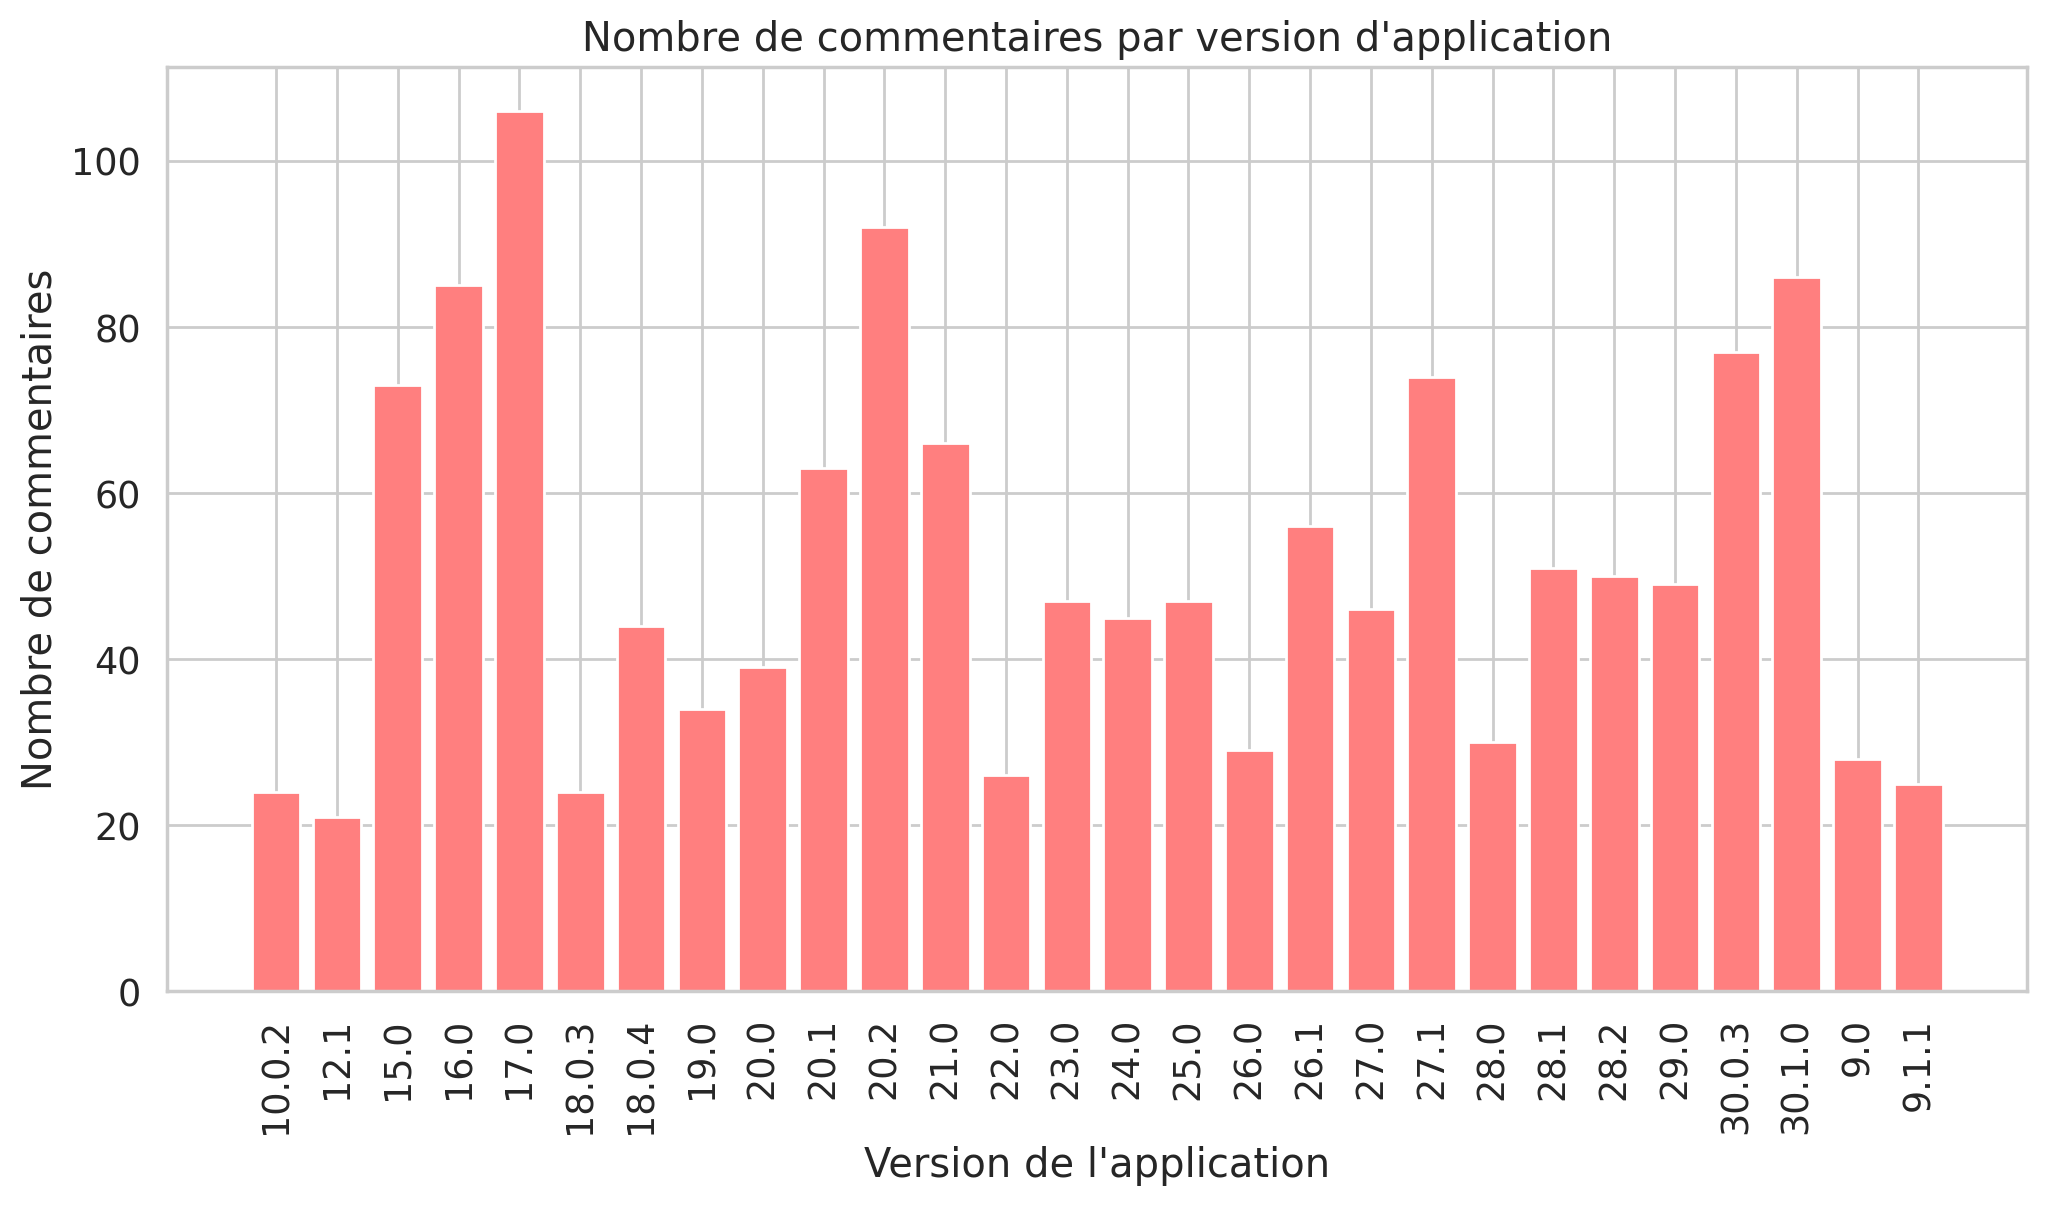

In [ ]:
# Visualisation du nombre de commentaires par version

nb_version = df.groupby('appVersion')['ID'].count().reset_index()
nb_version
nb_version = nb_version[nb_version['ID'] > 20] # Pour que le graphique soit lisible

# Triez les données par nombre de commentaires (en ordre décroissant)
nb_version = nb_version.sort_values(by='appVersion', ascending=True)

# Graphique à barres
plt.figure(figsize=(12, 6))
plt.bar(nb_version['appVersion'], nb_version['ID'], color='#FF7F7F')

# Pivoter les étiquettes de l'axe x pour une meilleure lisibilité
plt.xticks(rotation='vertical')

# Titres des axes
plt.title("Nombre de commentaires par version d'application")
plt.xlabel("Version de l'application")
plt.ylabel("Nombre de commentaires")
plt.show()

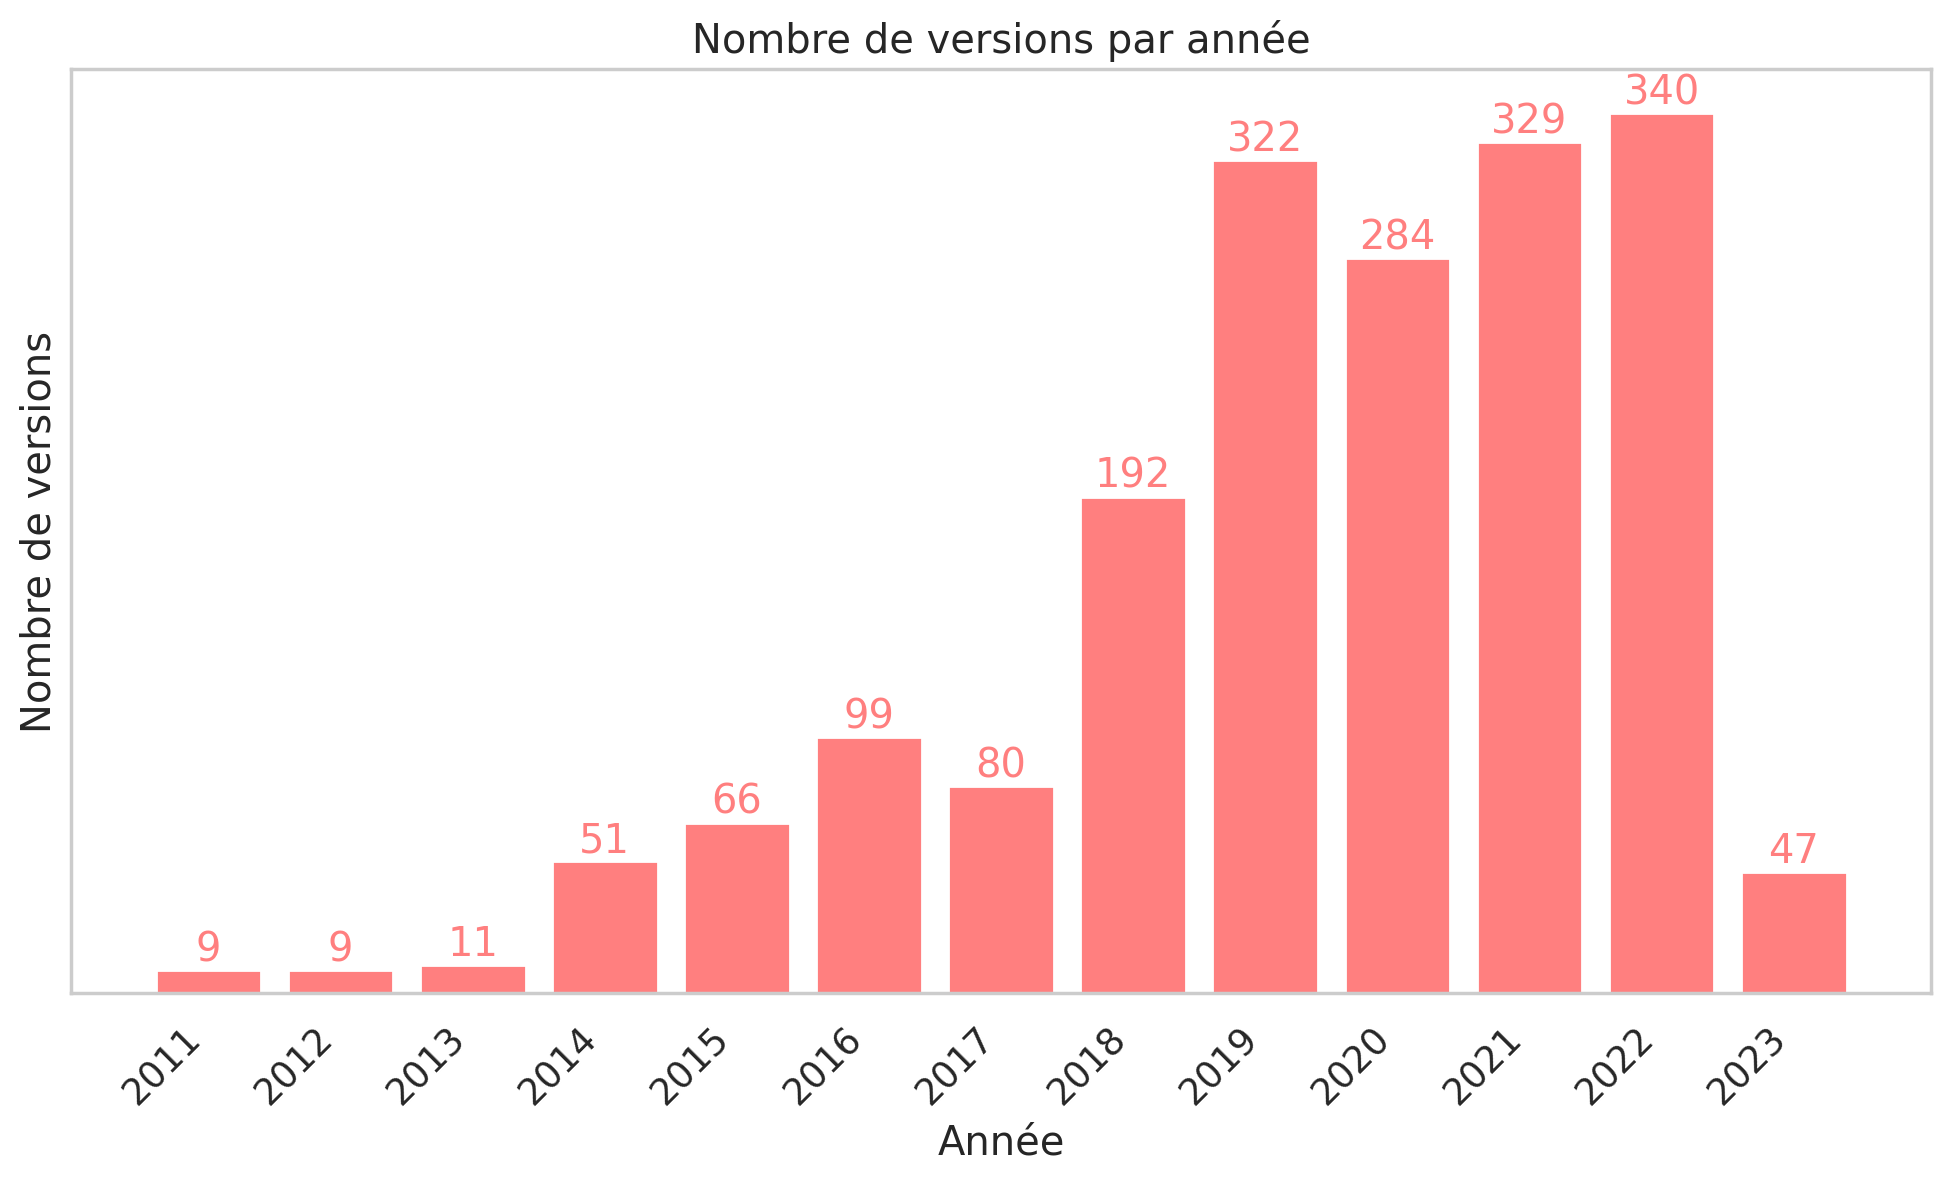

In [ ]:
# Visualisation du nombre de version par année
nb_version_annee = df.groupby('année')['appVersion'].count().reset_index()

# Graphique à barres
plt.figure(figsize=(12, 6))
bars = plt.bar(nb_version_annee['année'], nb_version_annee['appVersion'], color='#FF7F7F')

# Ajustez l'espacement entre les étiquettes de l'axe x
step = 1  # Réglez le pas en fonction de votre préférence (1 pour chaque année, 2 pour une année sur deux)
plt.xticks(nb_version_annee['année'][::step], rotation=45, ha='right')  # Utilisez 'ha' pour aligner correctement les étiquettes

plt.title("Nombre de versions par année")
plt.xlabel("Année")
plt.ylabel("Nombre de versions")
plt.yticks([])
plt.grid(False)

# Ajoutez des annotations pour les valeurs au-dessus de chaque barre avec la couleur rose
for bar in bars:
    height = round(bar.get_height(), 2)
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', color='#FF7F7F')

plt.show()

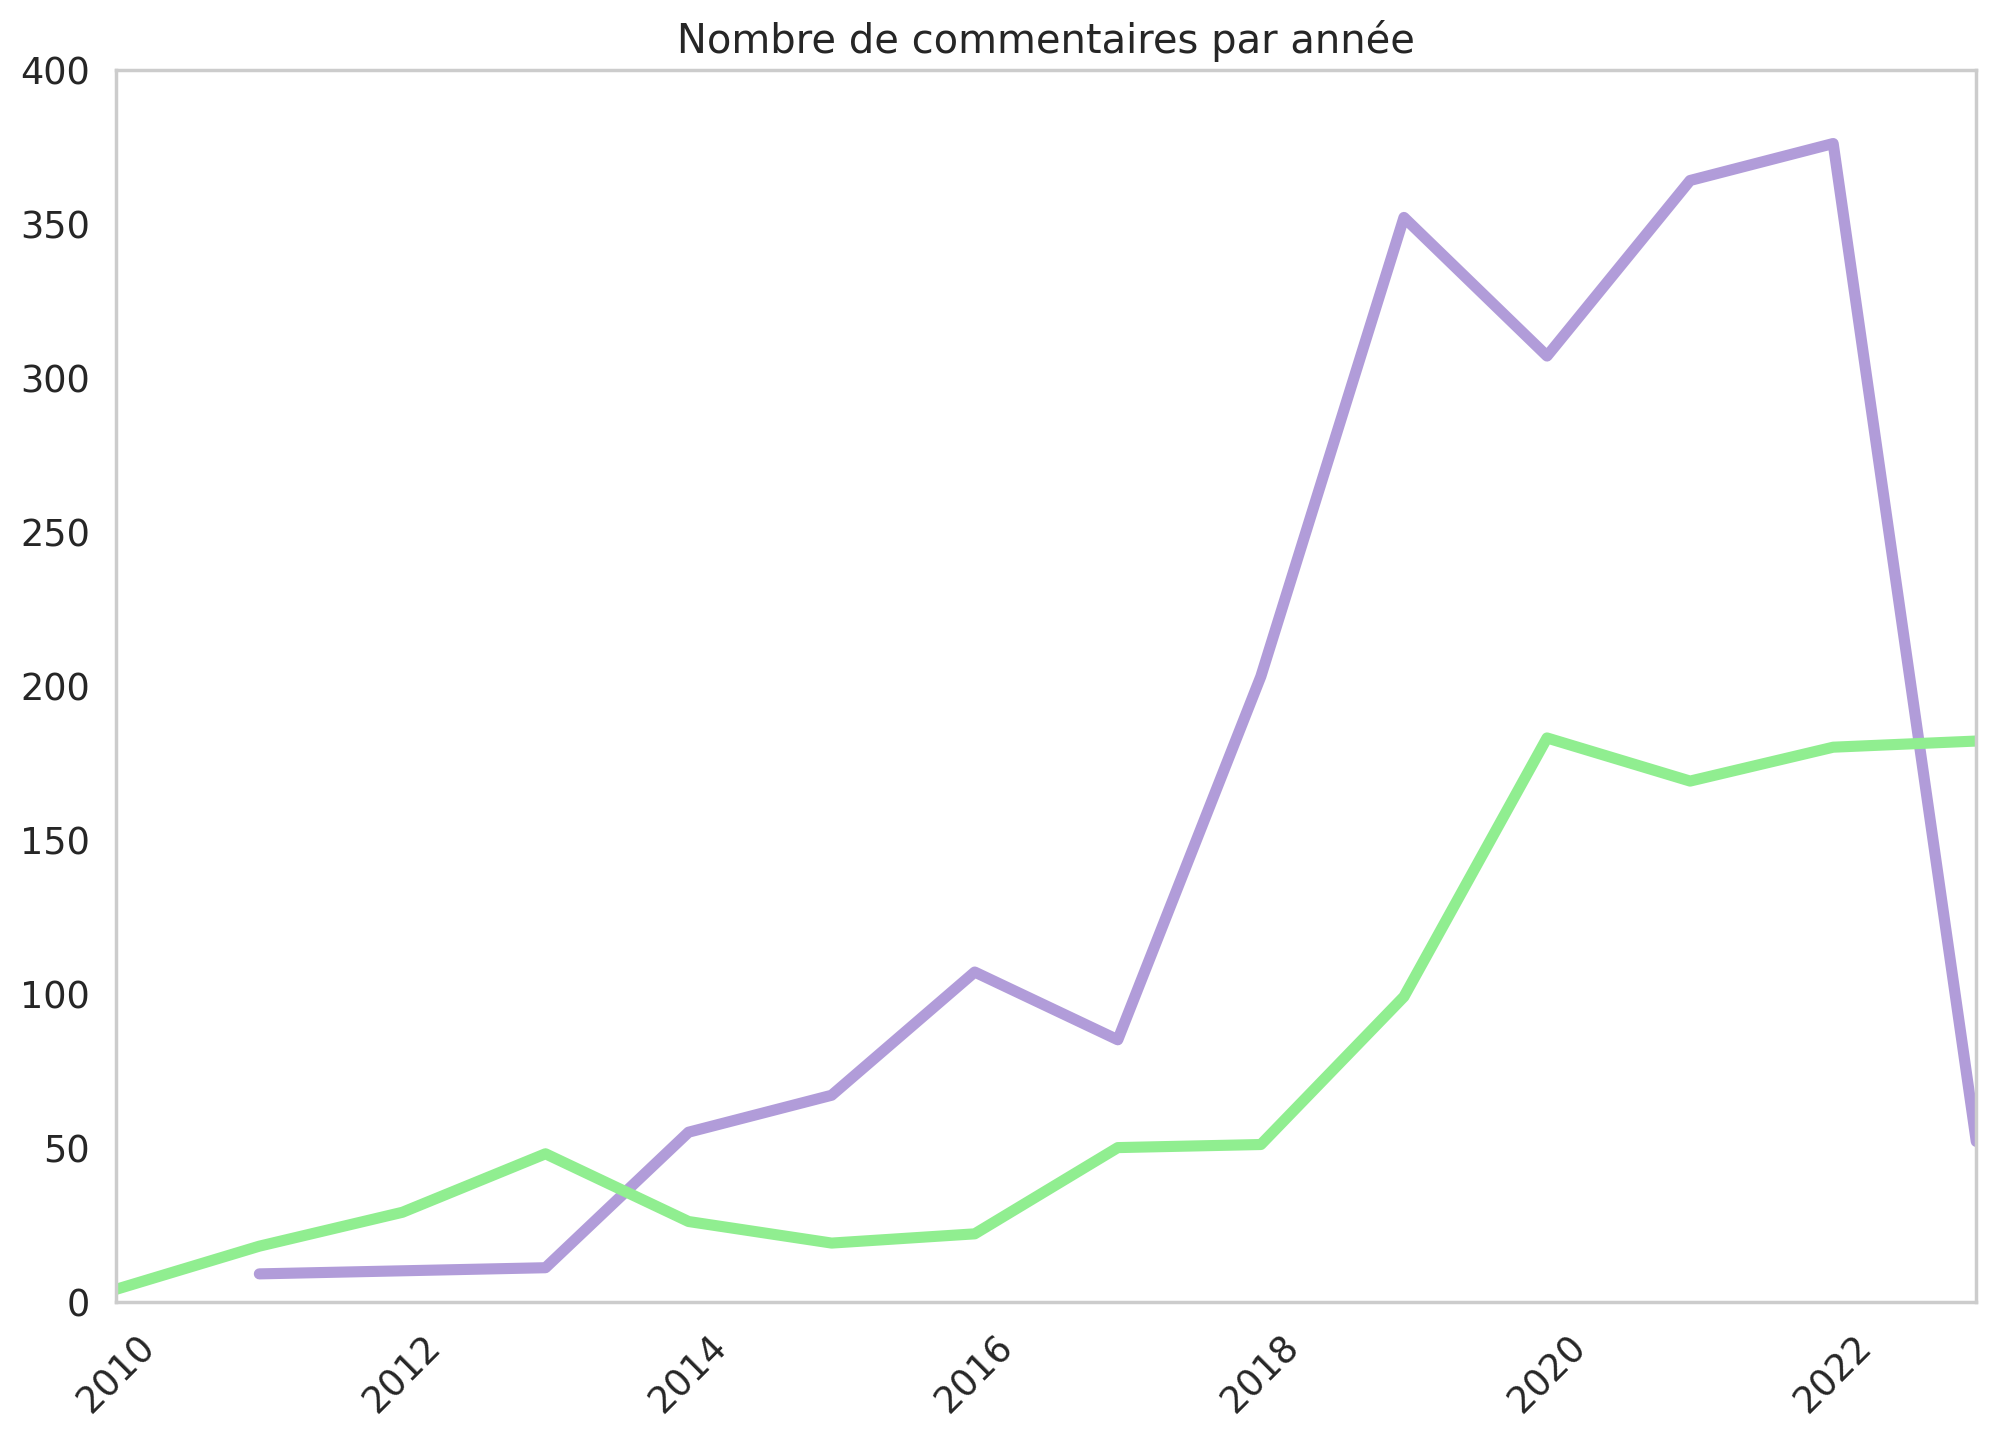

In [ ]:
# Evolution au cours du temps du nombre de commentaires
nb_avis = df.groupby('année')['ID'].count().reset_index() #ca
nb_avisBP = data.groupby('année')['ID'].count().reset_index() #bp

annees_continues = np.arange(nb_avis['année'].min(), nb_avis['année'].max() + 1)
annees_continuesBP = np.arange(nb_avisBP['année'].min(), nb_avis['année'].max() + 1)

plt.plot(annees_continues, nb_avis, linestyle='-', linewidth=4, color="#B19CD9")
plt.plot(annees_continuesBP, nb_avisBP, linestyle='-', linewidth=4, color="#90EE90")

plt.title("Nombre de commentaires par année")
plt.xticks(rotation=45)
plt.yticks([0,50,100,150,200,250,300,350,400])
plt.xlim(2010,2023) #définir la longueur de X
plt.ylim(0,400) # définir la longueur de Y
plt.grid(False) #enlever les grilles du graph
plt.show()

In [ ]:
df.info() # Type des variables pour le CA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1998 non-null   object        
 1   userName              1998 non-null   object        
 2   userImage             1998 non-null   object        
 3   content               1998 non-null   object        
 4   score                 1998 non-null   int64         
 5   thumbsUpCount         1998 non-null   int64         
 6   reviewCreatedVersion  1839 non-null   object        
 7   at                    1998 non-null   datetime64[ns]
 8   replyContent          129 non-null    object        
 9   repliedAt             129 non-null    datetime64[ns]
 10  appVersion            1839 non-null   object        
 11  ID                    1998 non-null   int64         
 12  date                  1998 non-null   datetime64[ns]
 13  année             

In [ ]:
data.info() # Type des variables pour BNP Paribas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1080 non-null   object        
 1   userName              1080 non-null   object        
 2   userImage             1080 non-null   object        
 3   content               1079 non-null   object        
 4   score                 1080 non-null   int64         
 5   thumbsUpCount         1080 non-null   int64         
 6   reviewCreatedVersion  970 non-null    object        
 7   at                    1080 non-null   datetime64[ns]
 8   replyContent          796 non-null    object        
 9   repliedAt             796 non-null    datetime64[ns]
 10  appVersion            970 non-null    object        
 11  ID                    1080 non-null   int64         
 12  date                  1080 non-null   datetime64[ns]
 13  année             

In [ ]:
df['score'].describe() # CA

count    1998.000000
mean        2.827828
std         1.617192
min         1.000000
25%         1.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: score, dtype: float64

In [ ]:
data['score'].describe() # BNP

count    1080.000000
mean        2.773148
std         1.714957
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max         5.000000
Name: score, dtype: float64

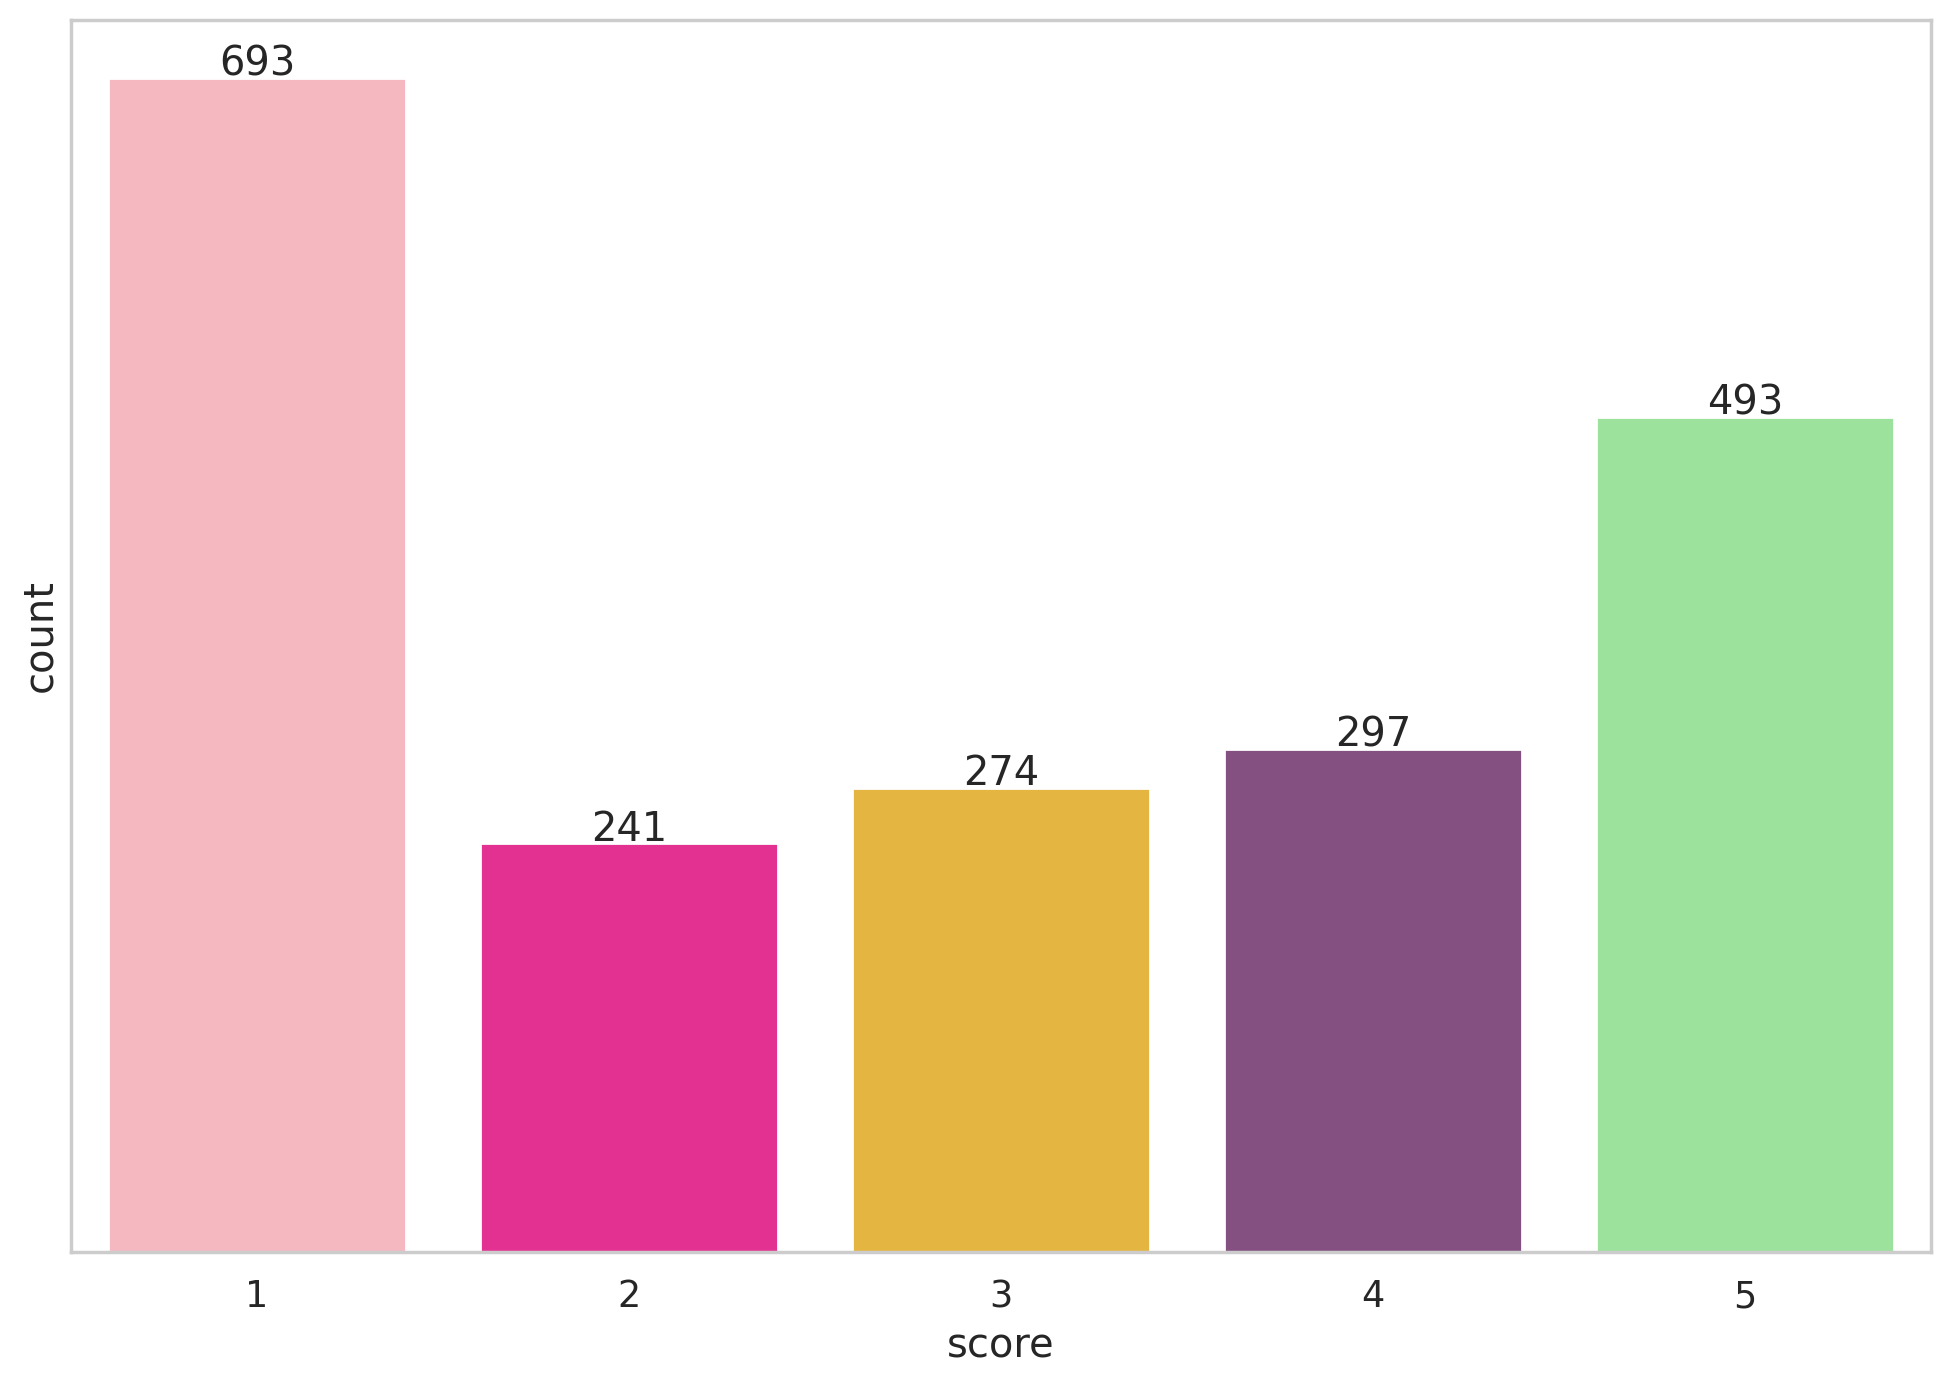

In [ ]:
# Nombre d'avis par note des clients du CA
ax = sns.countplot(data=df, x='score', order=[1, 2, 3, 4, 5])
ax.set_yticklabels([])
plt.yticks([])
plt.grid(False)

# Ajout des étiquettes au-dessus des barres
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

<Axes: ylabel='score'>

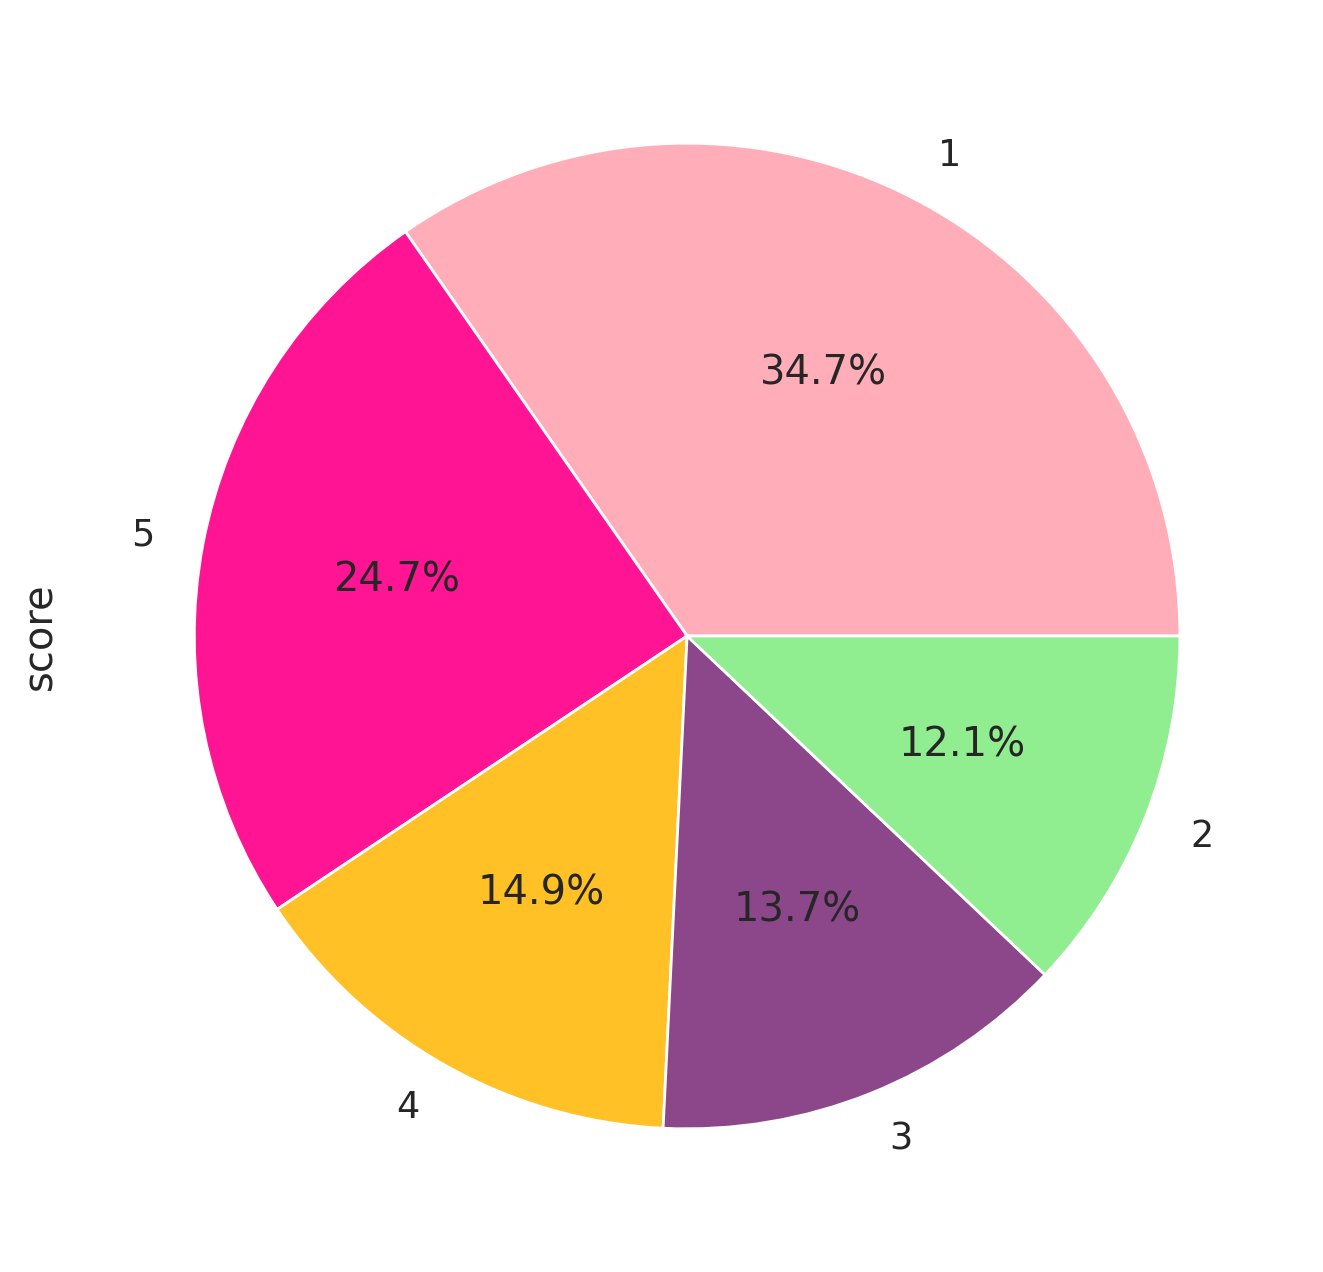

In [ ]:
# % d'avis par note des clients du CA
df['score'].value_counts().plot(kind='pie',figsize=(8,8), autopct='%1.1f%%')

<Axes: ylabel='score'>

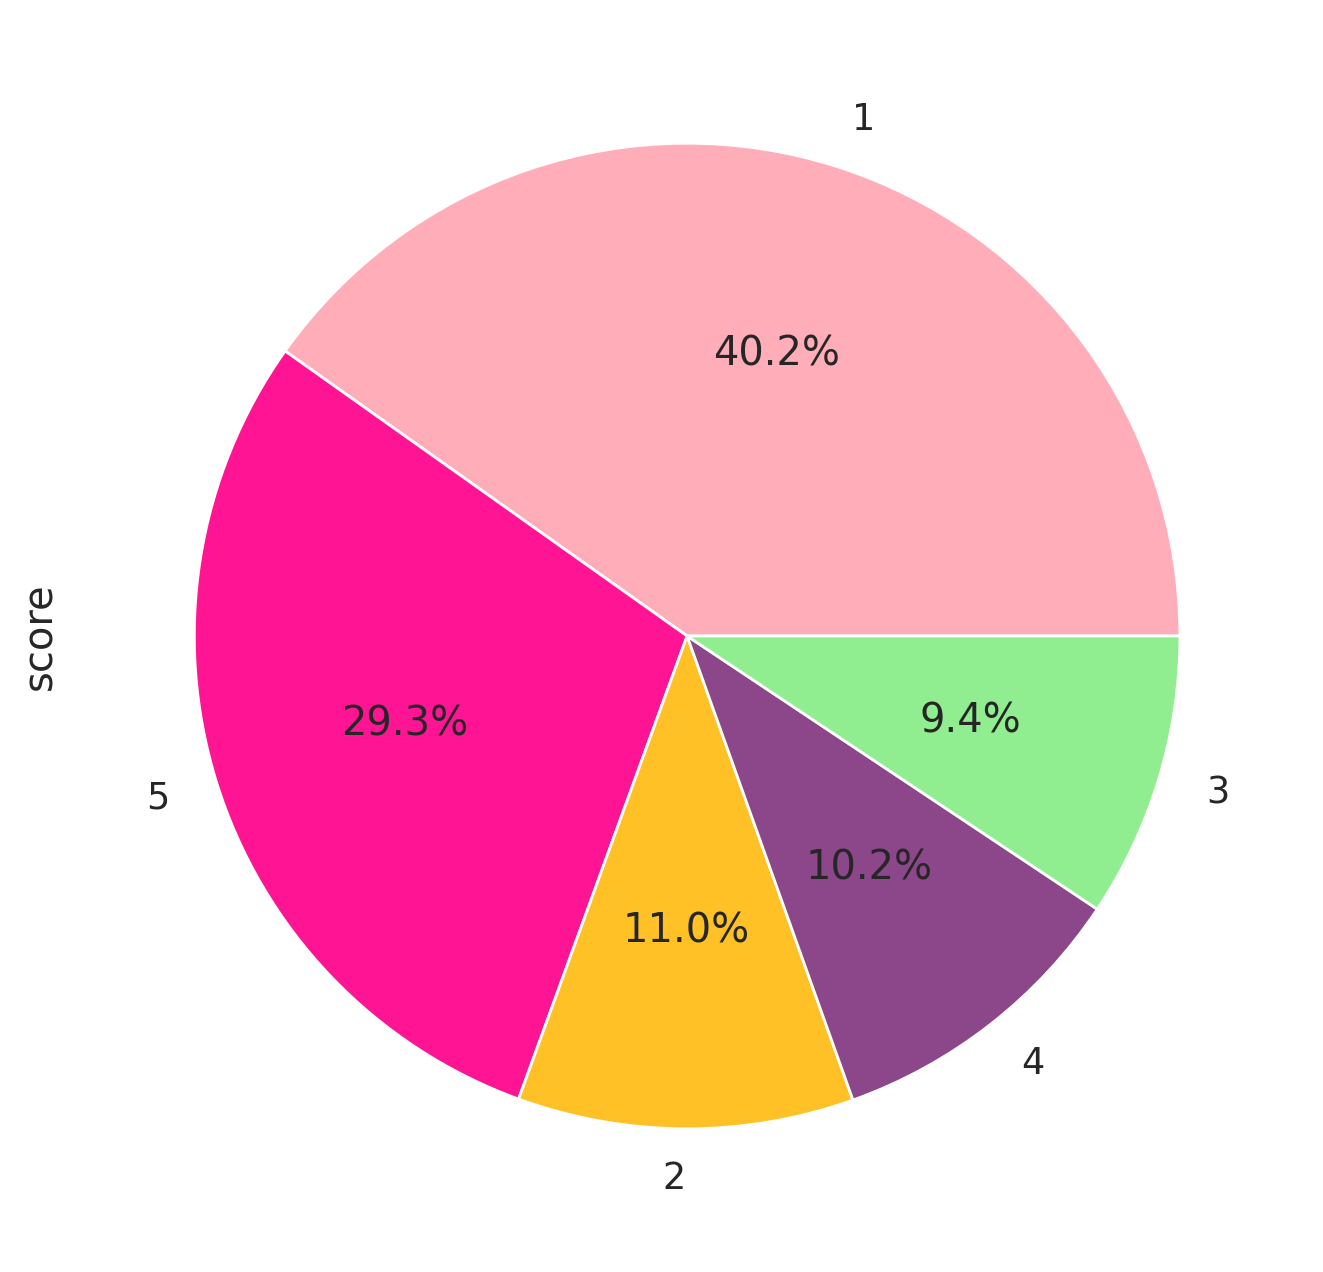

In [ ]:
data['score'].value_counts().plot(kind='pie',figsize=(8,8), autopct='%1.1f%%') # BNP PARIBAS

In [ ]:
# Création de sentiments en fonction des notes pour le CA
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
# Création de sentiments en fonction des notes pour BNP Paribas
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

data['sentiment'] = data.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

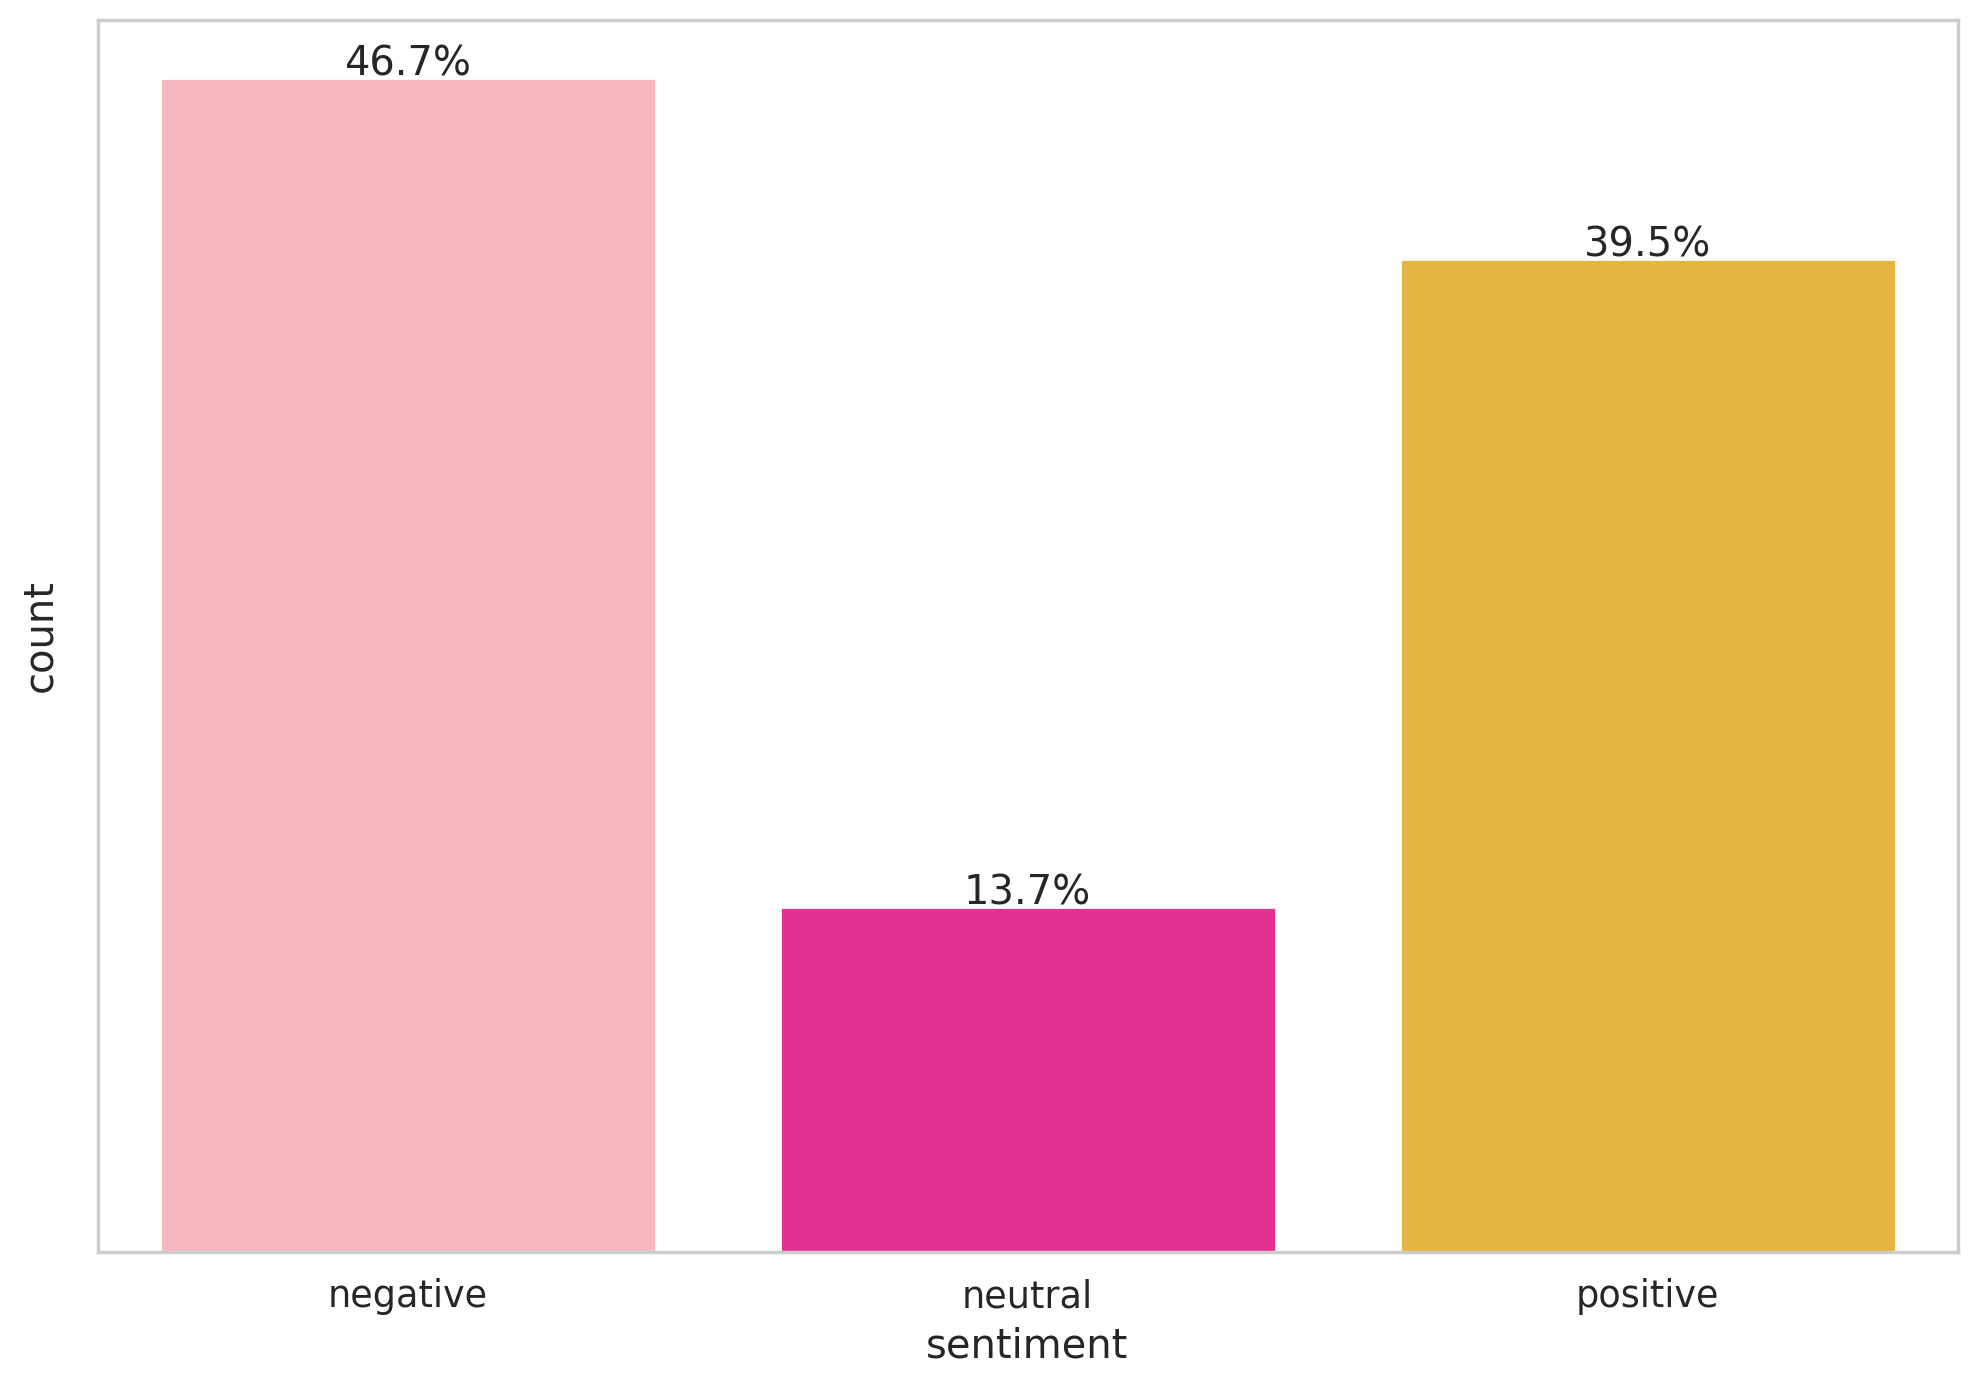

In [ ]:
# Visualisation de sentiments en fonction des notes du CA
ax = sns.countplot(data=df, x='sentiment')
ax.set_yticklabels([])

# Calculer les pourcentages pour chaque catégorie
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

# Ajoutez les étiquettes de l'axe x en pourcentage
class_names1 = [f'{c} ({count/total*100:.1f}%)' for c, count in zip(df['sentiment'].value_counts().index, df['sentiment'].value_counts())]
ax.set_xticklabels(class_names)

plt.grid(False)
plt.show()

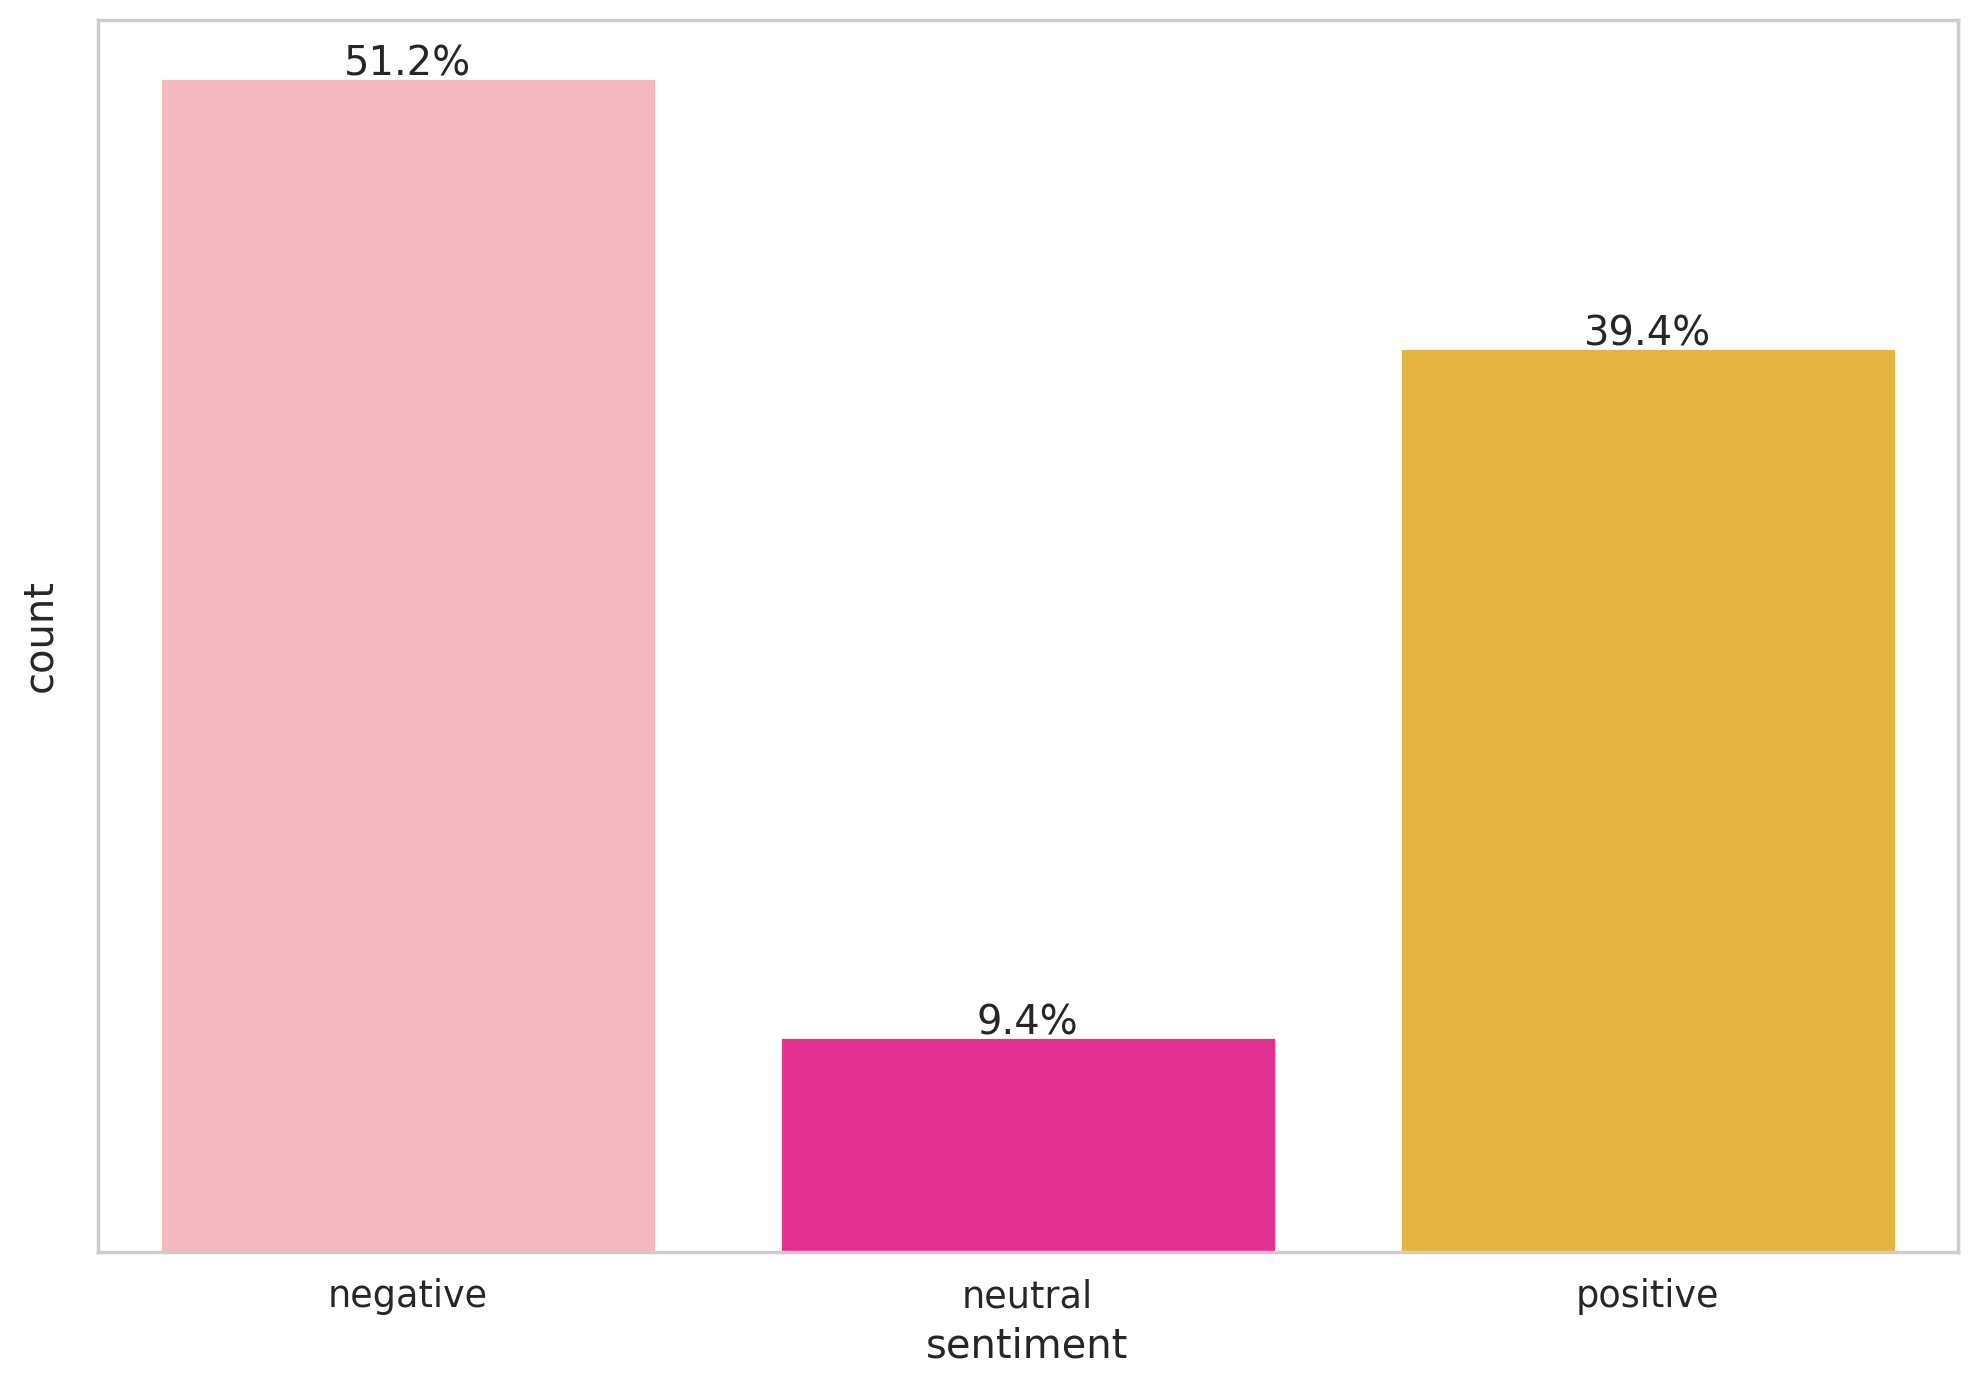

In [ ]:
# Visualisation de sentiments en fonction des notes de BNP Paribas
ax = sns.countplot(data=data, x='sentiment')
ax.set_yticklabels([])

# Calculer les pourcentages pour chaque catégorie
total = len(data)
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

# Ajoutez les étiquettes de l'axe x en pourcentage
class_names1 = [f'{c} ({count/total*100:.1f}%)' for c, count in zip(data['sentiment'].value_counts().index, data['sentiment'].value_counts())]
ax.set_xticklabels(class_names)

plt.grid(False)
plt.show()

# II Entrainnement du Modèle BERT sur le Crédit Agricole

# https://colab.research.google.com/drive/1xNzVVOcjkZey-GYsKnrIlyT0RLZZ81fs

Vous savez peut-être déjà que les modèles d'apprentissage automatique ne fonctionnent pas avec du texte brut. Vous devez convertir le texte en chiffres (d'une manière ou d'une autre). BERT requiert encore plus d'attention (bonne idée, n'est-ce pas ?). Voici les exigences :

- Ajouter des jetons spéciaux pour séparer les phrases et effectuer la classification
- Passer des séquences de longueur constante (introduire du padding)
- Créer un tableau de 0 (jeton de remplissage) et de 1 (jeton réel) appelé *masque d'attention*.

La bibliothèque Transformers fournit (vous l'avez deviné) une grande variété de modèles Transformer (y compris BERT). Elle fonctionne avec TensorFlow et PyTorch ! Elle inclut également des tokenizers pré-construits qui font le gros du travail pour nous !

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

> Vous pouvez utiliser une version casée et une version non casée de BERT et du tokenizer. J'ai expérimenté les deux. La version casée fonctionne mieux. Intuitivement, c'est logique, puisque "BAD" peut véhiculer plus de sentiments que "bad".

In [ ]:
# Découper un texte en entités plus petites appelées tokens
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer

BertTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
# On récupère les avis du Crédit Agricole
df_reviews=pd.DataFrame(df, columns=["content"])
df_reviews.head()

content
0  La nouvelle version de l'application est bien ...
1      Horrible !!!!! Returned a l'ancien programme.
2  Points négatifs : La gestion des virements par...
3  Appli géniale. Et l'équipe derrière est incroy...
4  Appli prototype Elle ne sert à rien. ( sauf co...

In [ ]:
# On passe les commentaires en liste
text = df_reviews['content'].tolist()
text

["La nouvelle version de l'application est bien meilleur et la double authentification est bien meilleure qu'avant. Bug: impossible d'uploader une pièce jointe dans mon espace de messagerie sécurisée",
 "Horrible !!!!! Returned a l'ancien programme.",
 "Points négatifs : La gestion des virements par message ne permet pas un suivi. La gestion des virements programmés est cachée dans paramètres. La messagerie a, de plus, parfois un affichage étrange. L'application se deconnecte trop souvent et interromp les actions en cours. La limite de 3000 Euros pour les virements est de mon point de vue incompréhensible. Les applications web et android sont tres différentes. Point positif : L'assurance Pacifica",
 "Appli géniale. Et l'équipe derrière est incroyable.",
 'Appli prototype Elle ne sert à rien. ( sauf consultation de ses comptes)',
 'La pire. Ergonomie 3/10. Fiabilité 0/10. Fonctionne uniquement quand elle le désire. Securipass indisponible rendant impossible toutes transactions en ligne.

In [ ]:
# Initialisation d'une liste pour stocker les tokens et les IDs
all_tokens = []
all_token_ids = []

# Itération sur chaque phrase dans la liste
for sentence in text:
    # Tokenization
    tokens = tokenizer.tokenize(sentence)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Ajout des tokens et des IDs aux listes globales
    all_tokens.append(tokens)
    all_token_ids.append(token_ids)

# Affichage
for i, sentence in enumerate(text):
    print(f'Sentence {i+1}: {sentence}')
    print(f'Tokens: {all_tokens[i]}')
    print(f'Token IDs: {all_token_ids[i]}')
    print()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Sentence 754: Superb
Tokens: ['Super', '##b']
Token IDs: [3198, 1830]

Sentence 755: Very good easy to usr
Tokens: ['Very', 'good', 'easy', 'to', 'us', '##r']
Token IDs: [6424, 1363, 3123, 1106, 1366, 1197]

Sentence 756: Marche jamais
Tokens: ['March', '##e', 'jam', '##ais']
Token IDs: [1345, 1162, 17462, 15837]

Sentence 757: actually its amazing 👏 good work
Tokens: ['actually', 'its', 'amazing', '[UNK]', 'good', 'work']
Token IDs: [2140, 1157, 6929, 100, 1363, 1250]

Sentence 758: It's great
Tokens: ['It', "'", 's', 'great']
Token IDs: [1135, 112, 188, 1632]

Sentence 759: Excellent not complicated to use but Security
Tokens: ['Excellent', 'not', 'complicated', 'to', 'use', 'but', 'Security']
Token IDs: [25764, 1136, 8277, 1106, 1329, 1133, 4354]

Sentence 760: it's good to use. Expecting English version.
Tokens: ['it', "'", 's', 'good', 'to', 'use', '.', 'Ex', '##pect', '##ing', 'English', 'version', '.']

Tokens spéciaux encodés

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  text,
  max_length=32,
  #truncation = True, # Pas de racourci de text ici, 512 max ici
  add_special_tokens=True, # Ajout de '[CLS]' and '[SEP]'
  return_token_type_ids=False, # Nous ne voulons pas obtenir les identifiants de type de token
  pad_to_max_length=True, # Cela indique au tokenizer de remplir automatiquement la séquence d'encodage pour qu'elle atteigne la longueur maximale spécifiée PAD
  return_attention_mask=True, # MASK
  return_tensors='pt',  # Cela indique que l'on souhaite que les sorties soient retournées sous forme de tenseurs PyTorch ('pt')
)

encoding.keys() #  Ligne qui renvoie les clés de l'objet (id, mask, pad, cls, ...)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   100,   100,   100,   100,   100,   100,   100,   100,   100,
          100,   100,   100,   100,   100,   100,   100,   100,   100,   100,
          100, 18970,   100,   100,   100,   100,   100,   100,   100,   100,
          100,   102])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 'pathetic',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[SEP]']

In [ ]:
# Adapter la longueur des tokens
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

<ipython-input-39-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


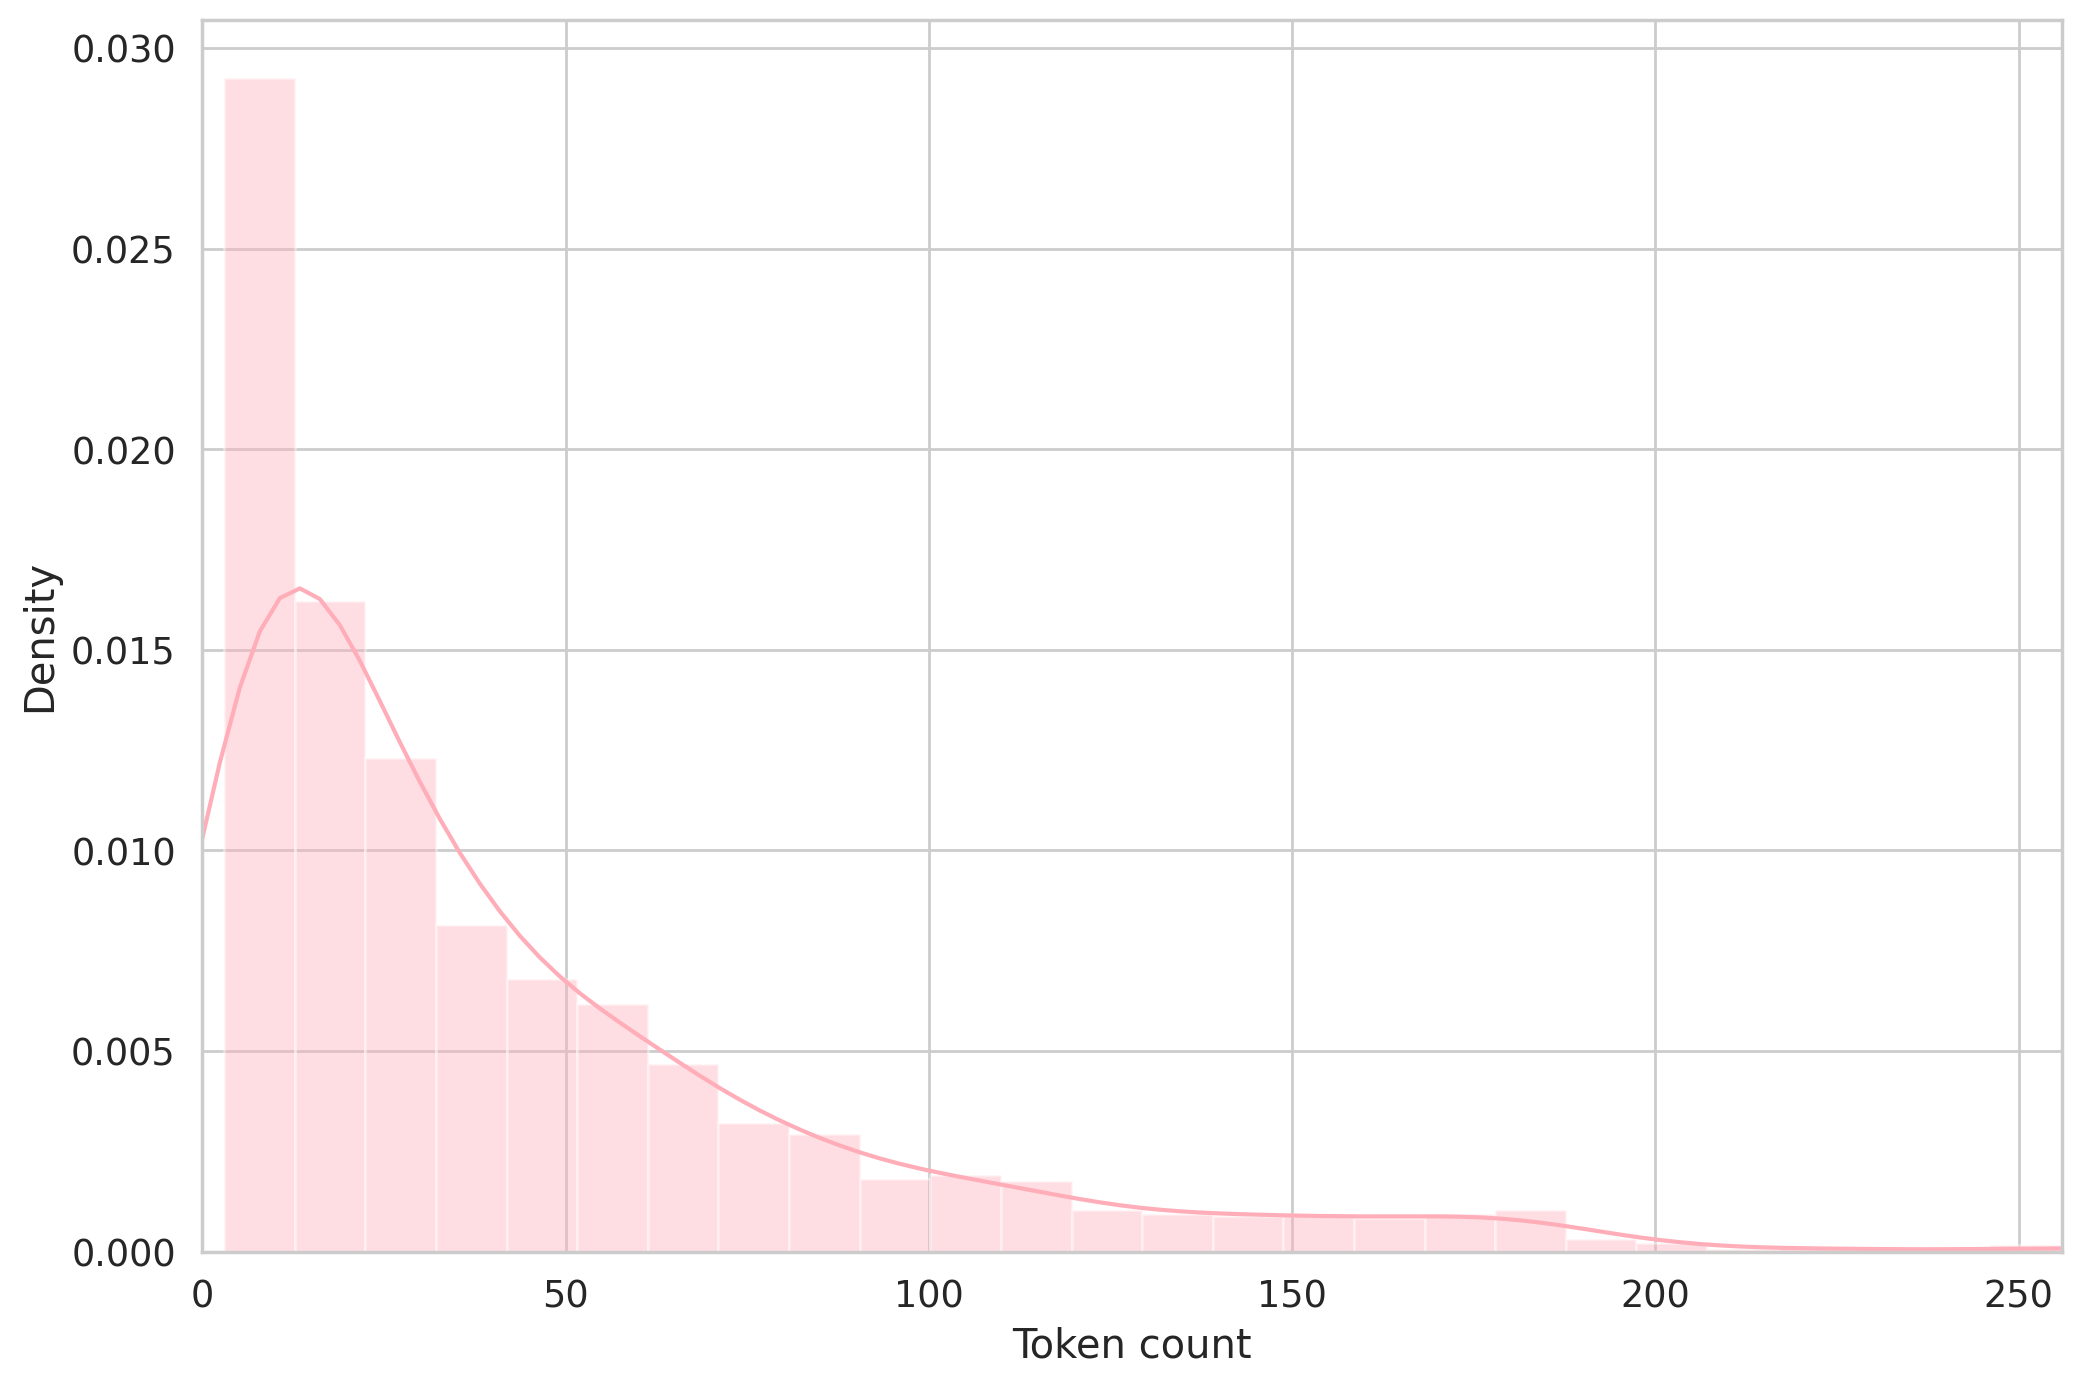

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 220

In [ ]:
# Paramètres du modèle BERT pour comprendre les commentaires des clients
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# SPLIT du modèle
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((1798, 15), (100, 15), (100, 15))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 220])
torch.Size([16, 220])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [ ]:
last_hidden_state = bert_model(**encoding).last_hidden_state
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
pooled_output = last_hidden_state[:,0,:]
pooled_output.shape

torch.Size([1, 768])

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3,)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 220])
torch.Size([16, 220])


In [ ]:
# Matrice de poids
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2267, 0.4651, 0.3082],
        [0.2260, 0.3704, 0.4036],
        [0.3167, 0.2656, 0.4178],
        [0.2257, 0.3228, 0.4516],
        [0.5498, 0.2063, 0.2440],
        [0.2525, 0.3785, 0.3690],
        [0.2576, 0.3348, 0.4076],
        [0.3934, 0.2250, 0.3816],
        [0.3813, 0.2007, 0.4181],
        [0.3245, 0.2108, 0.4647],
        [0.3021, 0.2361, 0.4618],
        [0.3408, 0.1942, 0.4650],
        [0.2005, 0.4131, 0.3864],
        [0.2528, 0.3369, 0.4103],
        [0.3824, 0.2327, 0.3849],
        [0.1318, 0.3491, 0.5191]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
EPOCHS = 10

# AdamW est déprécié : utiliser plutôt torch.optim.AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, no_deprecation_warning=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Entraînement du modèle BERT sur les données
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

Train loss 0.8701244712667128 accuracy 0.6368186874304783


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.49291156019483295 accuracy 0.81

Epoch 2/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6523012030968623 accuracy 0.7647385984427141


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.4665523213999612 accuracy 0.85

Epoch 3/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.49062941190415776 accuracy 0.8164627363737486


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.5333581918052265 accuracy 0.81

Epoch 4/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.35232994229062997 accuracy 0.8776418242491657


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.584711200424603 accuracy 0.8200000000000001

Epoch 5/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.2583861592250456 accuracy 0.9210233592880979


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.809944363044841 accuracy 0.73

Epoch 6/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.17908545979092608 accuracy 0.9471635150166852


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.9475788331723639 accuracy 0.75

Epoch 7/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.11145219982980825 accuracy 0.9727474972191323


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.9284690243325063 accuracy 0.79

Epoch 8/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.08426028559297587 accuracy 0.9810901001112347


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.9932967746364219 accuracy 0.81

Epoch 9/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.050972740949889794 accuracy 0.9888765294771968


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 1.0254667747233595 accuracy 0.81

Epoch 10/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.04621453458274327 accuracy 0.9877641824249166


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 1.0309274039297764 accuracy 0.81

CPU times: user 11min 52s, sys: 8.95 s, total: 12min 1s
Wall time: 12min 26s


In [ ]:
train_data_loader

In [ ]:
print(history['train_acc'])
print(history['val_acc'])

[tensor(0.6368, device='cuda:0', dtype=torch.float64), tensor(0.7647, device='cuda:0', dtype=torch.float64), tensor(0.8165, device='cuda:0', dtype=torch.float64), tensor(0.8776, device='cuda:0', dtype=torch.float64), tensor(0.9210, device='cuda:0', dtype=torch.float64), tensor(0.9472, device='cuda:0', dtype=torch.float64), tensor(0.9727, device='cuda:0', dtype=torch.float64), tensor(0.9811, device='cuda:0', dtype=torch.float64), tensor(0.9889, device='cuda:0', dtype=torch.float64), tensor(0.9878, device='cuda:0', dtype=torch.float64)]
[tensor(0.8100, device='cuda:0', dtype=torch.float64), tensor(0.8500, device='cuda:0', dtype=torch.float64), tensor(0.8100, device='cuda:0', dtype=torch.float64), tensor(0.8200, device='cuda:0', dtype=torch.float64), tensor(0.7300, device='cuda:0', dtype=torch.float64), tensor(0.7500, device='cuda:0', dtype=torch.float64), tensor(0.7900, device='cuda:0', dtype=torch.float64), tensor(0.8100, device='cuda:0', dtype=torch.float64), tensor(0.8100, device='cud

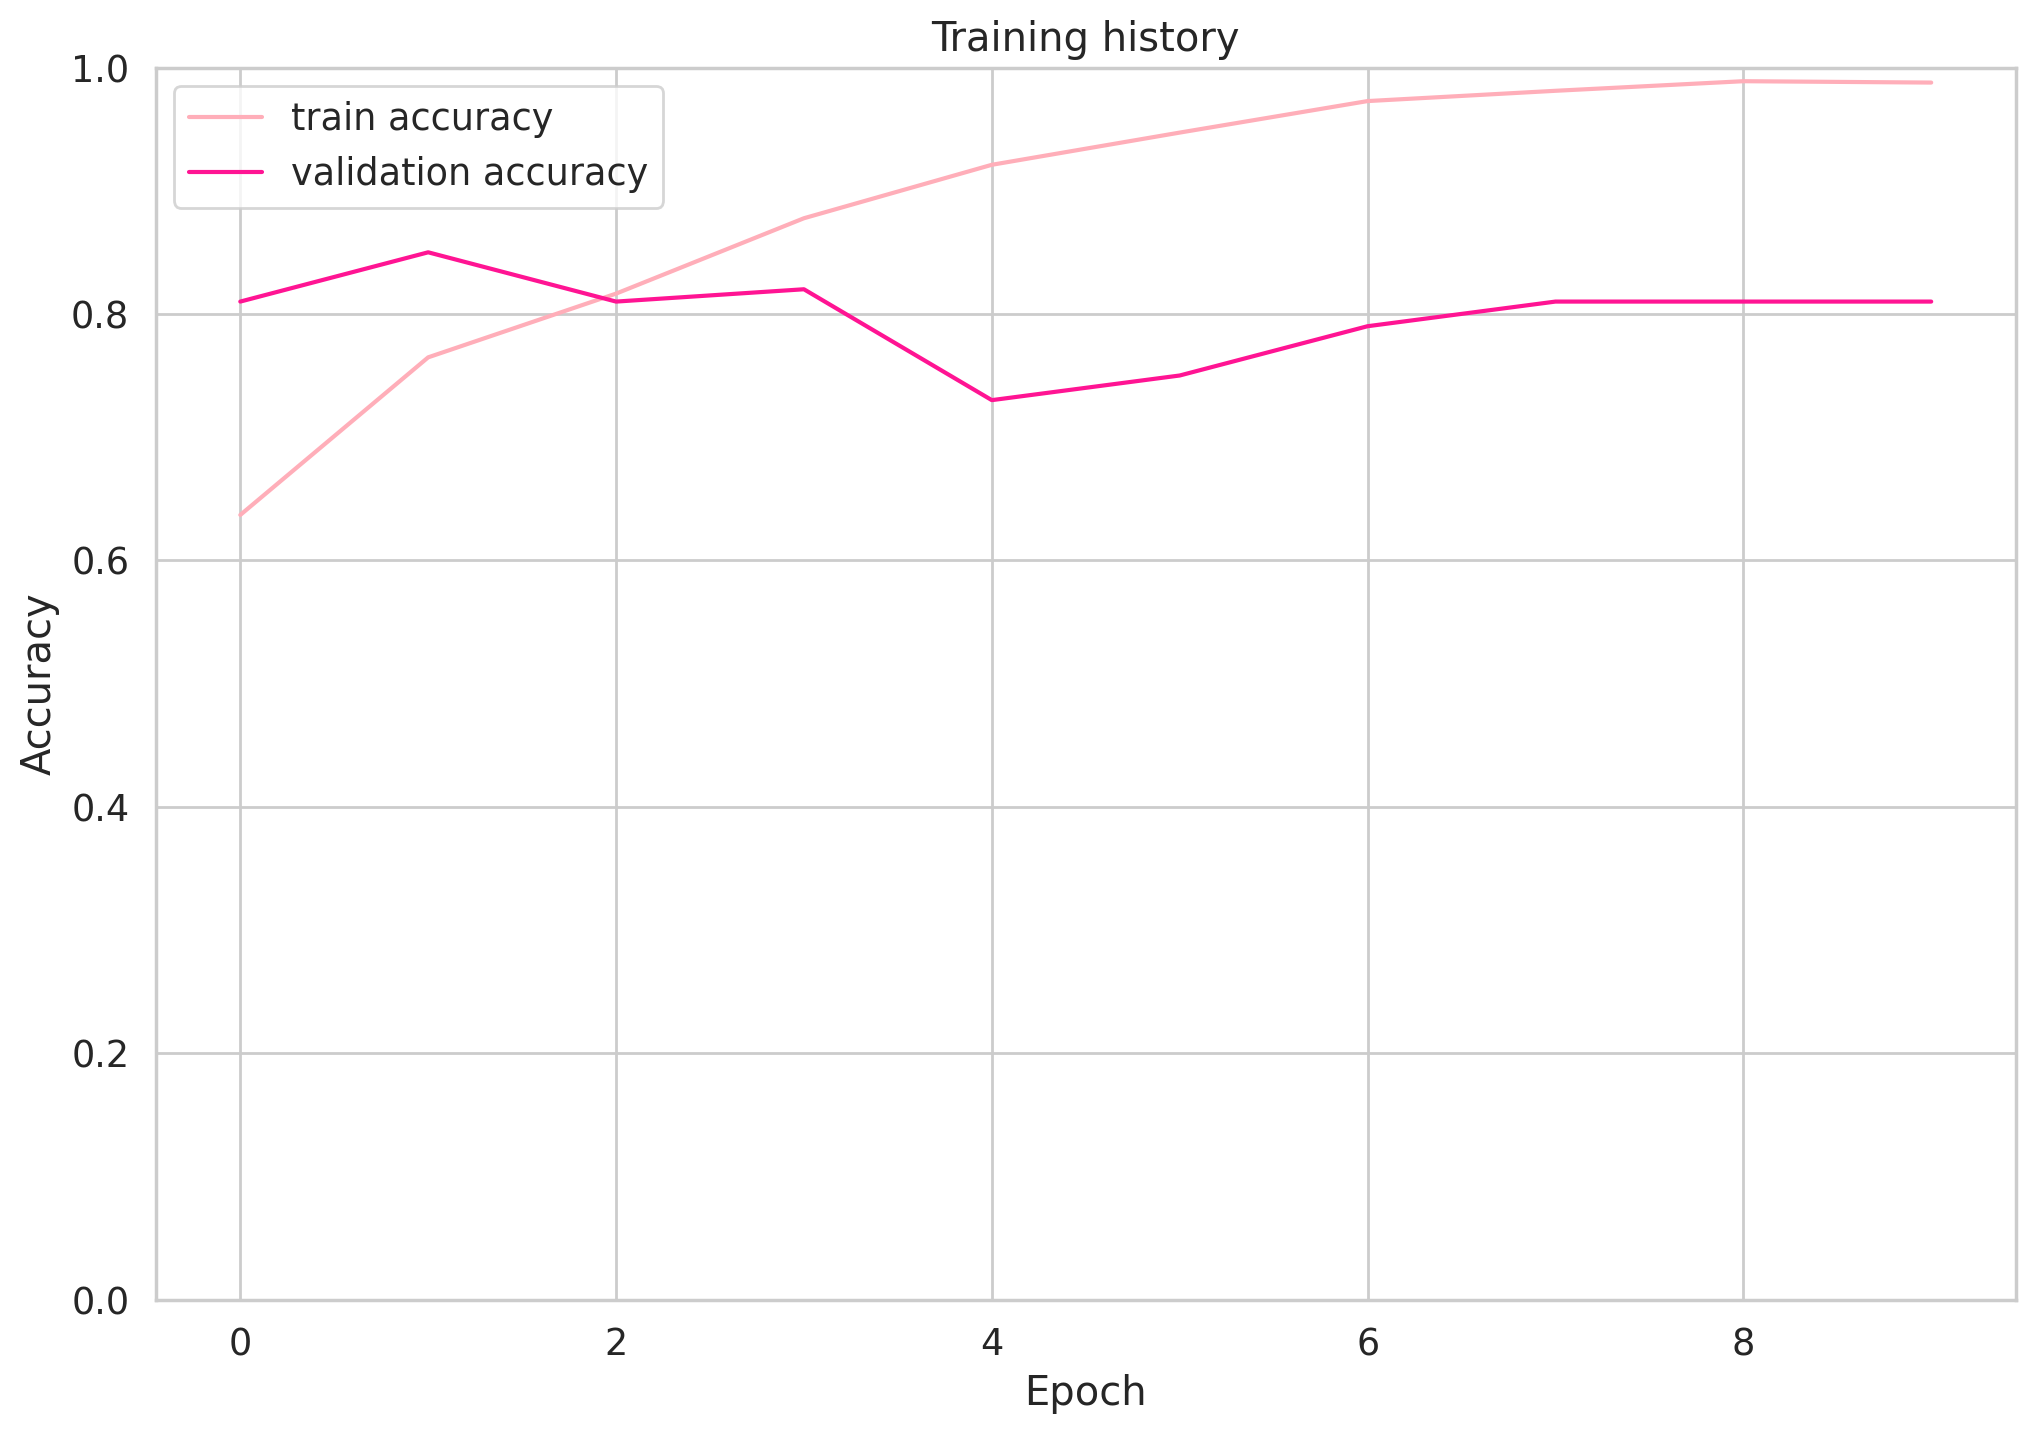

In [ ]:
# Convertir les tenseurs GPU en tableaux NumPy sur le CPU
train_acc = [t.item() for t in history['train_acc']]
val_acc = [t.item() for t in history['val_acc']]

# Maintenant, vous pouvez créer le graphique comme suit
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Prédiction du modèle sur les données test
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

0.73

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.79      0.81      0.80        47
     neutral       0.33      0.43      0.38        14
    positive       0.85      0.74      0.79        39

    accuracy                           0.73       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.75      0.73      0.74       100



In [ ]:
y_pred

tensor([2, 1, 2, 0, 2, 1, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0,
        0, 2, 0, 1, 0, 2, 2, 2, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0, 0, 1, 0, 2,
        2, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 1, 0, 1, 0, 2, 0, 2, 2, 1, 0, 0, 2, 0, 2, 0, 0, 1, 2, 1, 1,
        0, 2, 1, 0])

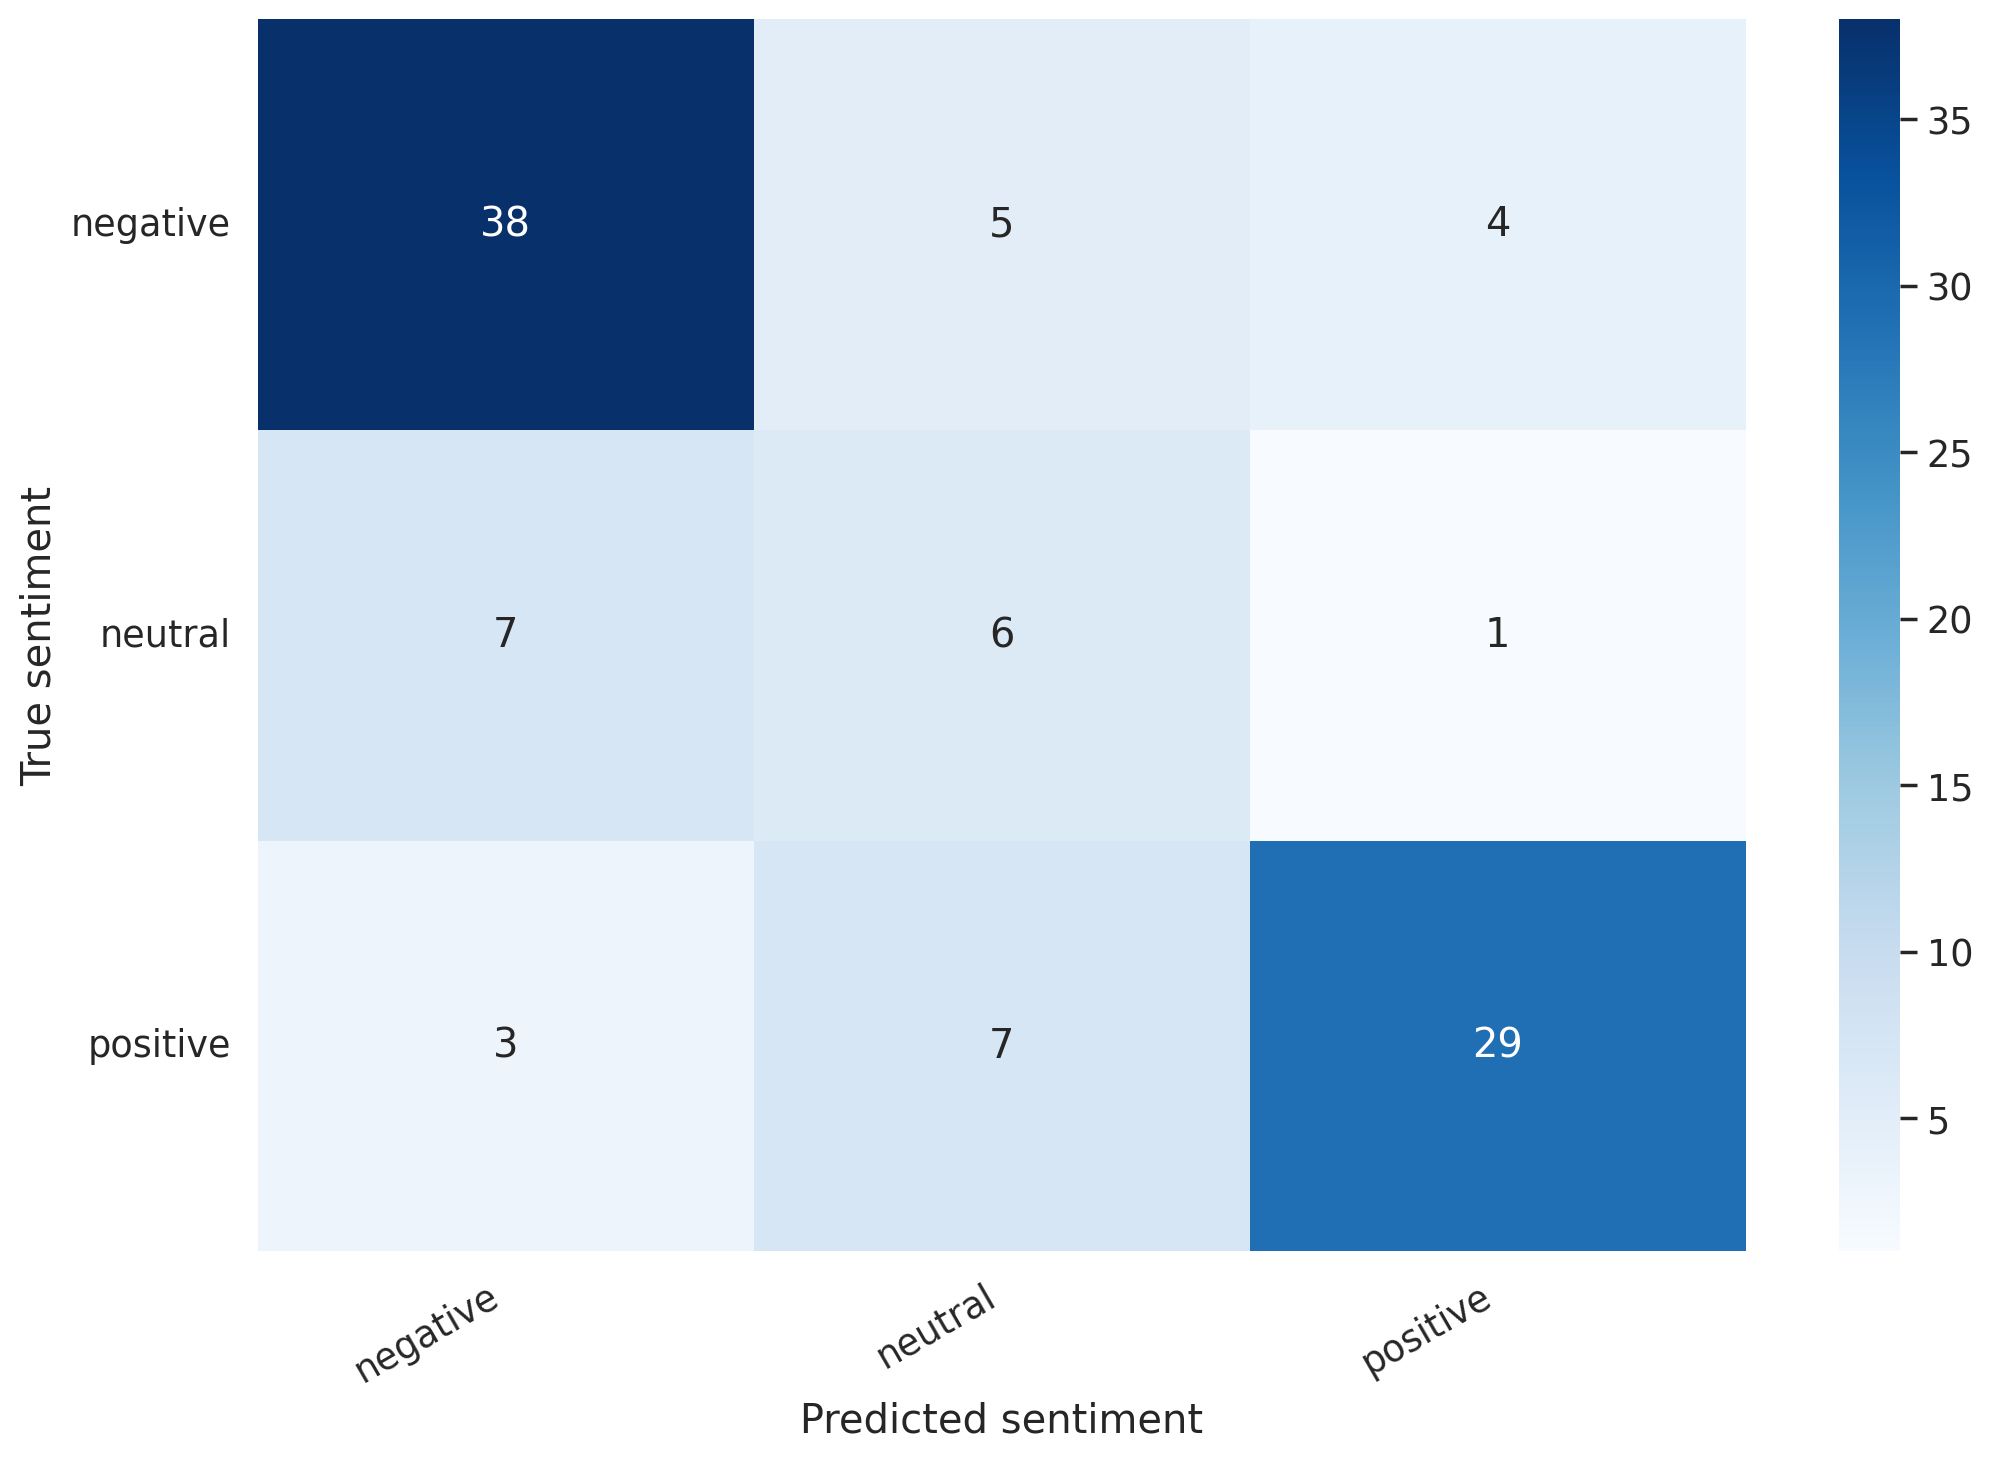

In [ ]:
# Matrice de confusion
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

L'application fonctionne bien mais l'information y est mal organisée

True sentiment: neutral


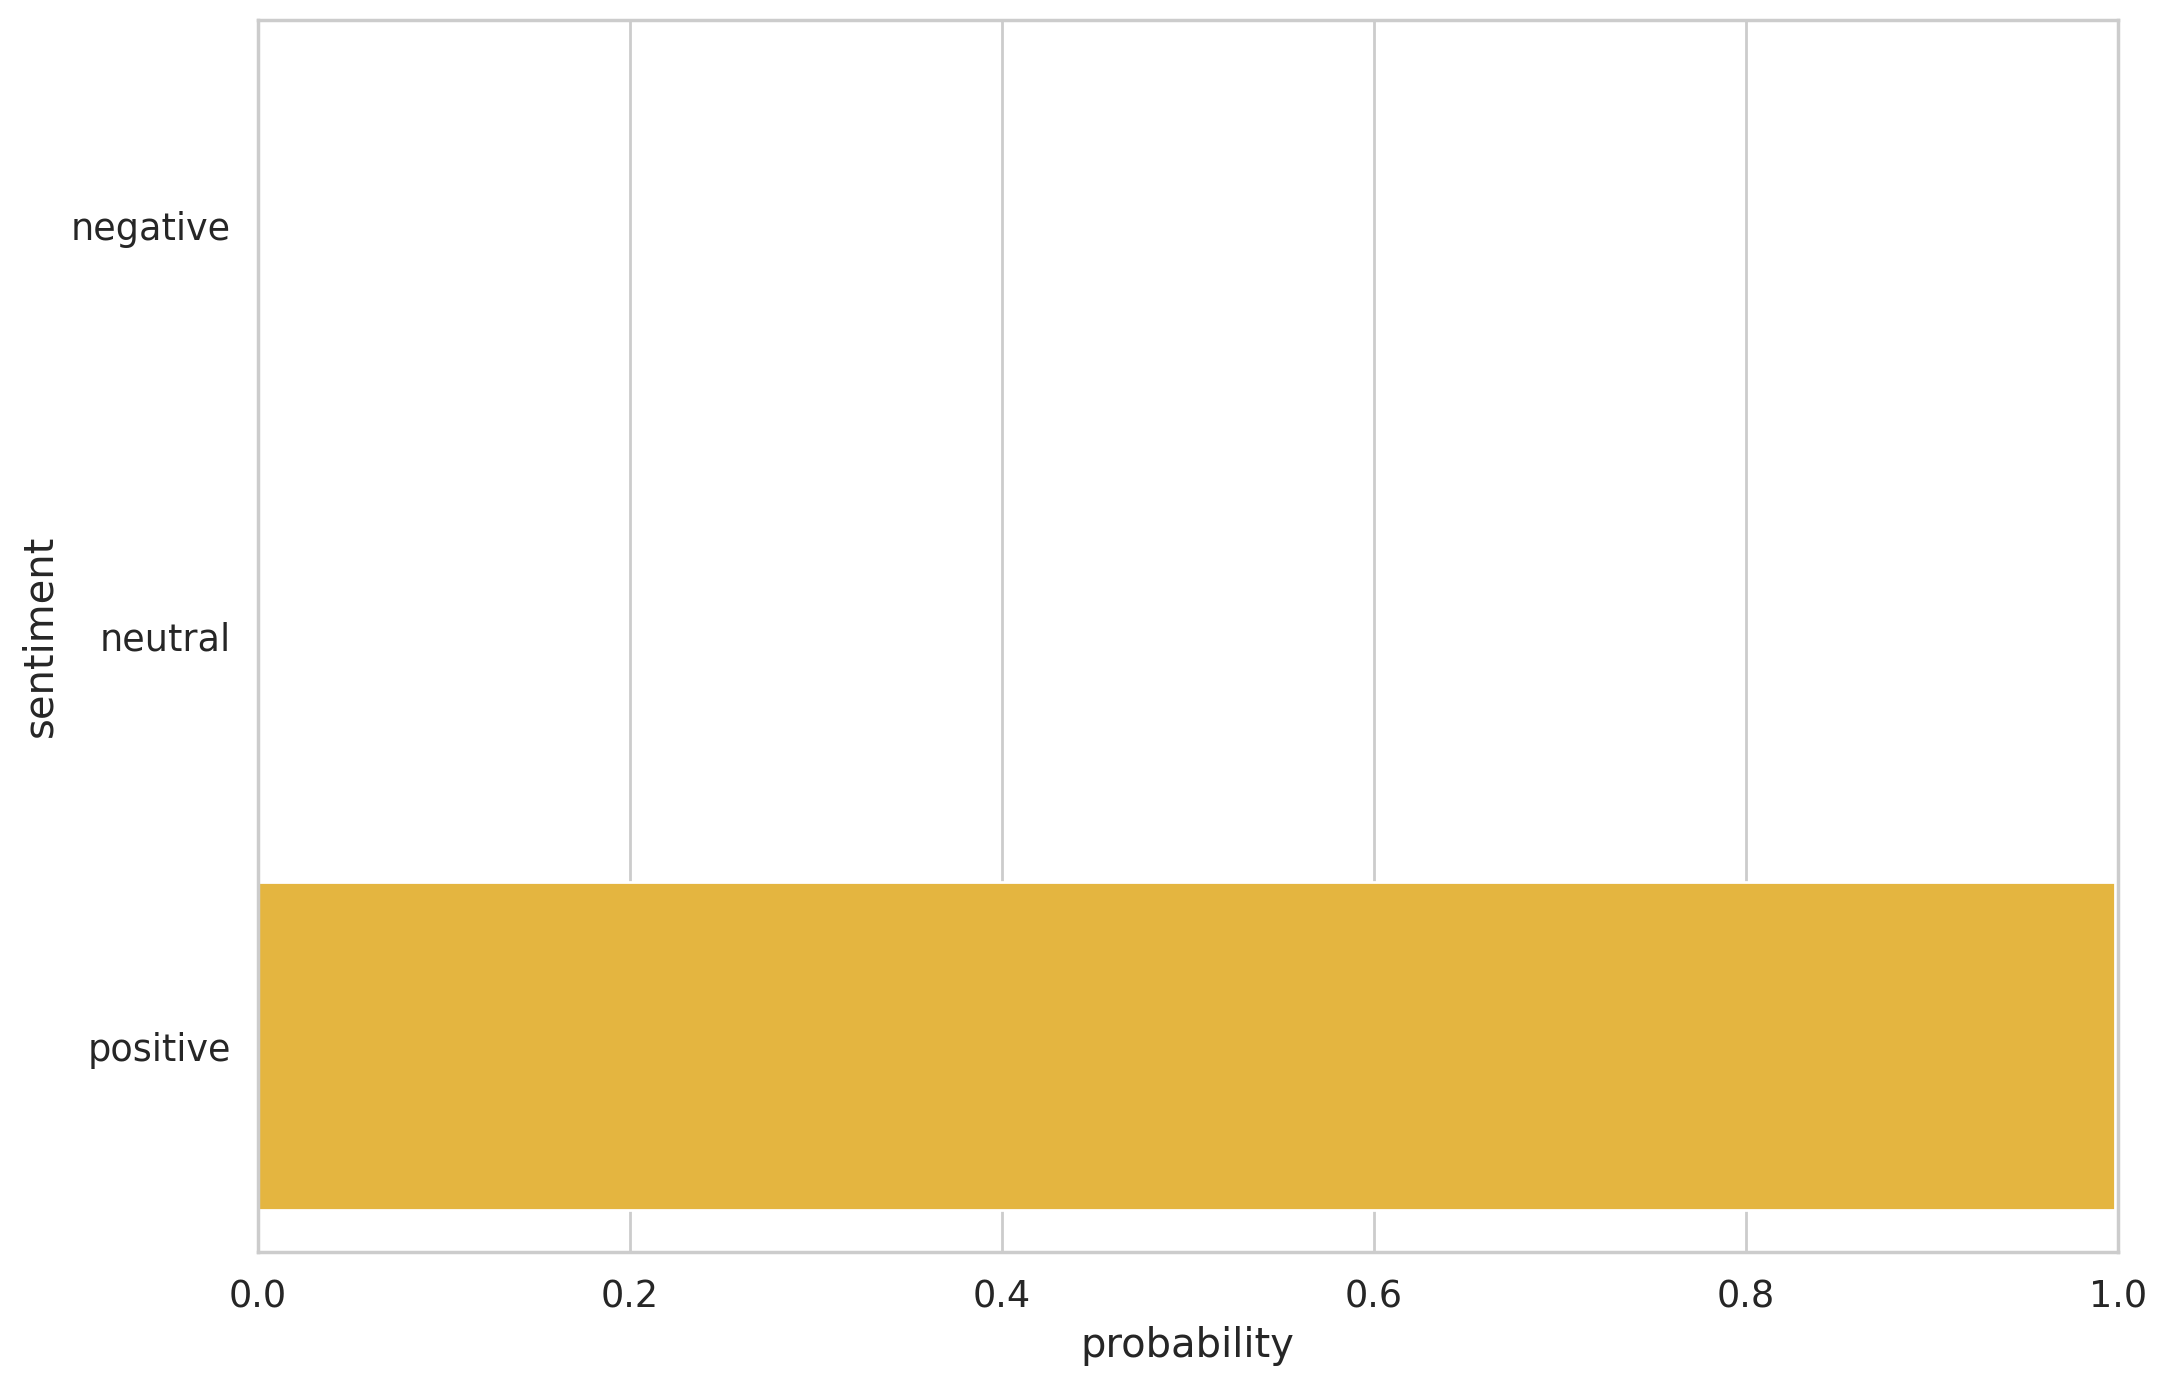

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
# Test
review_text = "Horrible !!!!! Returned a l'ancien programme."
# "Appli géniale. Et l'équipe derrière est incroyable."

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Test qui prédit bien le sentiment des phrases
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Horrible !!!!! Returned a l'ancien programme.
Sentiment  : negative


In [ ]:
# Créer une liste pour stocker toutes les prédictions
predictions = []

# Itérer sur chaque commentaire dans la colonne 'content'
for content in df['content']:
    # Encoder le commentaire de la même manière que précédemment
    encoded_review = tokenizer.encode_plus(
        content,
        add_special_tokens=True,
        max_length=220,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    # Obtenir les prédictions pour le commentaire actuel
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    # Ajouter la prédiction à la liste des prédictions
    predictions.append(class_names[prediction])

# Ajouter la liste des prédictions en tant que nouvelle colonne 'sentiment' au DataFrame
df['sentiment2'] = predictions

# Afficher le DataFrame avec la colonne 'sentiment' ajoutée
df.head()

reviewId                          userName  \
0  7a8ae8ca-f2ad-4624-90f1-72f928e8d080                       Jules Azman   
1  f93249e2-0396-41dd-a532-2a3b999e8aea                   Roselyne Petrus   
2  51cdc82f-460b-4289-ab3e-3c6db93cfc4e                    Mickael Dijoux   
3  af0bb9d2-1449-4f80-ae18-8b179523c293  Matthew “daoctopuss” Bartholomew   
4  67b87068-ddc3-4ce9-8b3e-a3060164e260                      Brice Dumont   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a/ACg8oc...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a/ACg8oc...   

                                             content  score  thumbsUpCount  \
0  La nouvelle version de l'application est bien ...      3              3   
1      Horrible !!!!! Returned a l'ancien programme.      1              0   
2  Points négatifs : La gestion des virements par...      1              0   
3  Appli géniale. Et l'équipe derrière est incroy...      5              0   
4  Appli prototype Elle ne sert à rien. ( sauf co...      1              0   

  reviewCreatedVersion                  at replyContent repliedAt appVersion  \
0              31.11.0 2023-10-10 10:30:00         None       NaT    31.11.0   
1              31.10.0 2023-09-16 19:26:22         None       NaT    31.10.0   
2                 None 2023-09-13 05:00:39         None       NaT       None   
3              31.10.0 2023-09-12 13:18:26         None       NaT    31.10.0   
4               31.8.0 2023-08-29 09:42:47         None       NaT     31.8.0   

   ID                date  année  sentiment sentiment2  
0   1 2023-10-10 10:30:00   2023          1    neutral  
1   2 2023-09-16 19:26:22   2023          0   negative  
2   3 2023-09-13 05:00:39   2023          0   negative  
3   4 2023-09-12 13:18:26   2023          2   positive  
4   5 2023-08-29 09:42:47   2023          0   negative

# III Nuage de mots du Crédit Agricole

In [ ]:
!pip install wordcloud

In [ ]:
nltk.download('stopwords')
_french = set(list(stopwords.words('french'))+list(STOPWORDS))
print(_french)

cloud = WordCloud(
    background_color='white',
    max_words=200,
    stopwords=_french
)

text = df['content'].tolist()
text = [item for item in text if item is not None]
texte_combine = " ".join(text)
texte_combine = texte_combine.lower()
texte_combine

{'fussions', 'suis', 'since', 'while', 'eussiez', "wasn't", 'only', 'we', 'votre', "they'll", 'tes', 'http', 'your', 'étante', 'eue', 'ourselves', 'above', 'étés', "haven't", 'sois', 'no', 'from', 'down', 'ai', 'him', 'étant', 'eûmes', 'the', 'étaient', "where's", "can't", 'few', 'to', 'fût', 'all', 'else', "we're", 'du', 'be', 'do', 'you', 'nous', 'before', "hasn't", 'auras', 'which', "i'd", 'ce', 'i', 'aurait', 'leur', 'itself', 'il', 'what', "how's", 'tu', "she's", 'hence', 'been', 'why', "we'll", 'étiez', 'his', 'eues', "mustn't", 'auraient', 'on', "let's", 'into', 'que', 'd', 'aies', "isn't", 'over', 'such', 'with', 'nos', 'le', 'n', 'eussions', 'being', 'did', 'eût', 'than', "you've", 'also', 'notre', 'son', 'ma', 'at', "i'm", 'eûtes', 'again', 'je', 'soyez', 'avions', 'yourself', 'should', 'avons', 'yourselves', 'ont', 'through', 'ayantes', 'during', 'aura', 'ses', 'cannot', 'serais', 'qui', 'by', 'aurais', 'elle', 'some', 'eu', 'par', 'ces', 'but', 'most', 'same', 'other', 'fur

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'la nouvelle version de l\'application est bien meilleur et la double authentification est bien meilleure qu\'avant. bug: impossible d\'uploader une pièce jointe dans mon espace de messagerie sécurisée horrible !!!!! returned a l\'ancien programme. points négatifs : la gestion des virements par message ne permet pas un suivi. la gestion des virements programmés est cachée dans paramètres. la messagerie a, de plus, parfois un affichage étrange. l\'application se deconnecte trop souvent et interromp les actions en cours. la limite de 3000 euros pour les virements est de mon point de vue incompréhensible. les applications web et android sont tres différentes. point positif : l\'assurance pacifica appli géniale. et l\'équipe derrière est incroyable. appli prototype elle ne sert à rien. ( sauf consultation de ses comptes) la pire. ergonomie 3/10. fiabilité 0/10. fonctionne uniquement quand elle le désire. securipass indisponible rendant impossible toutes transactions en ligne. faites un eff

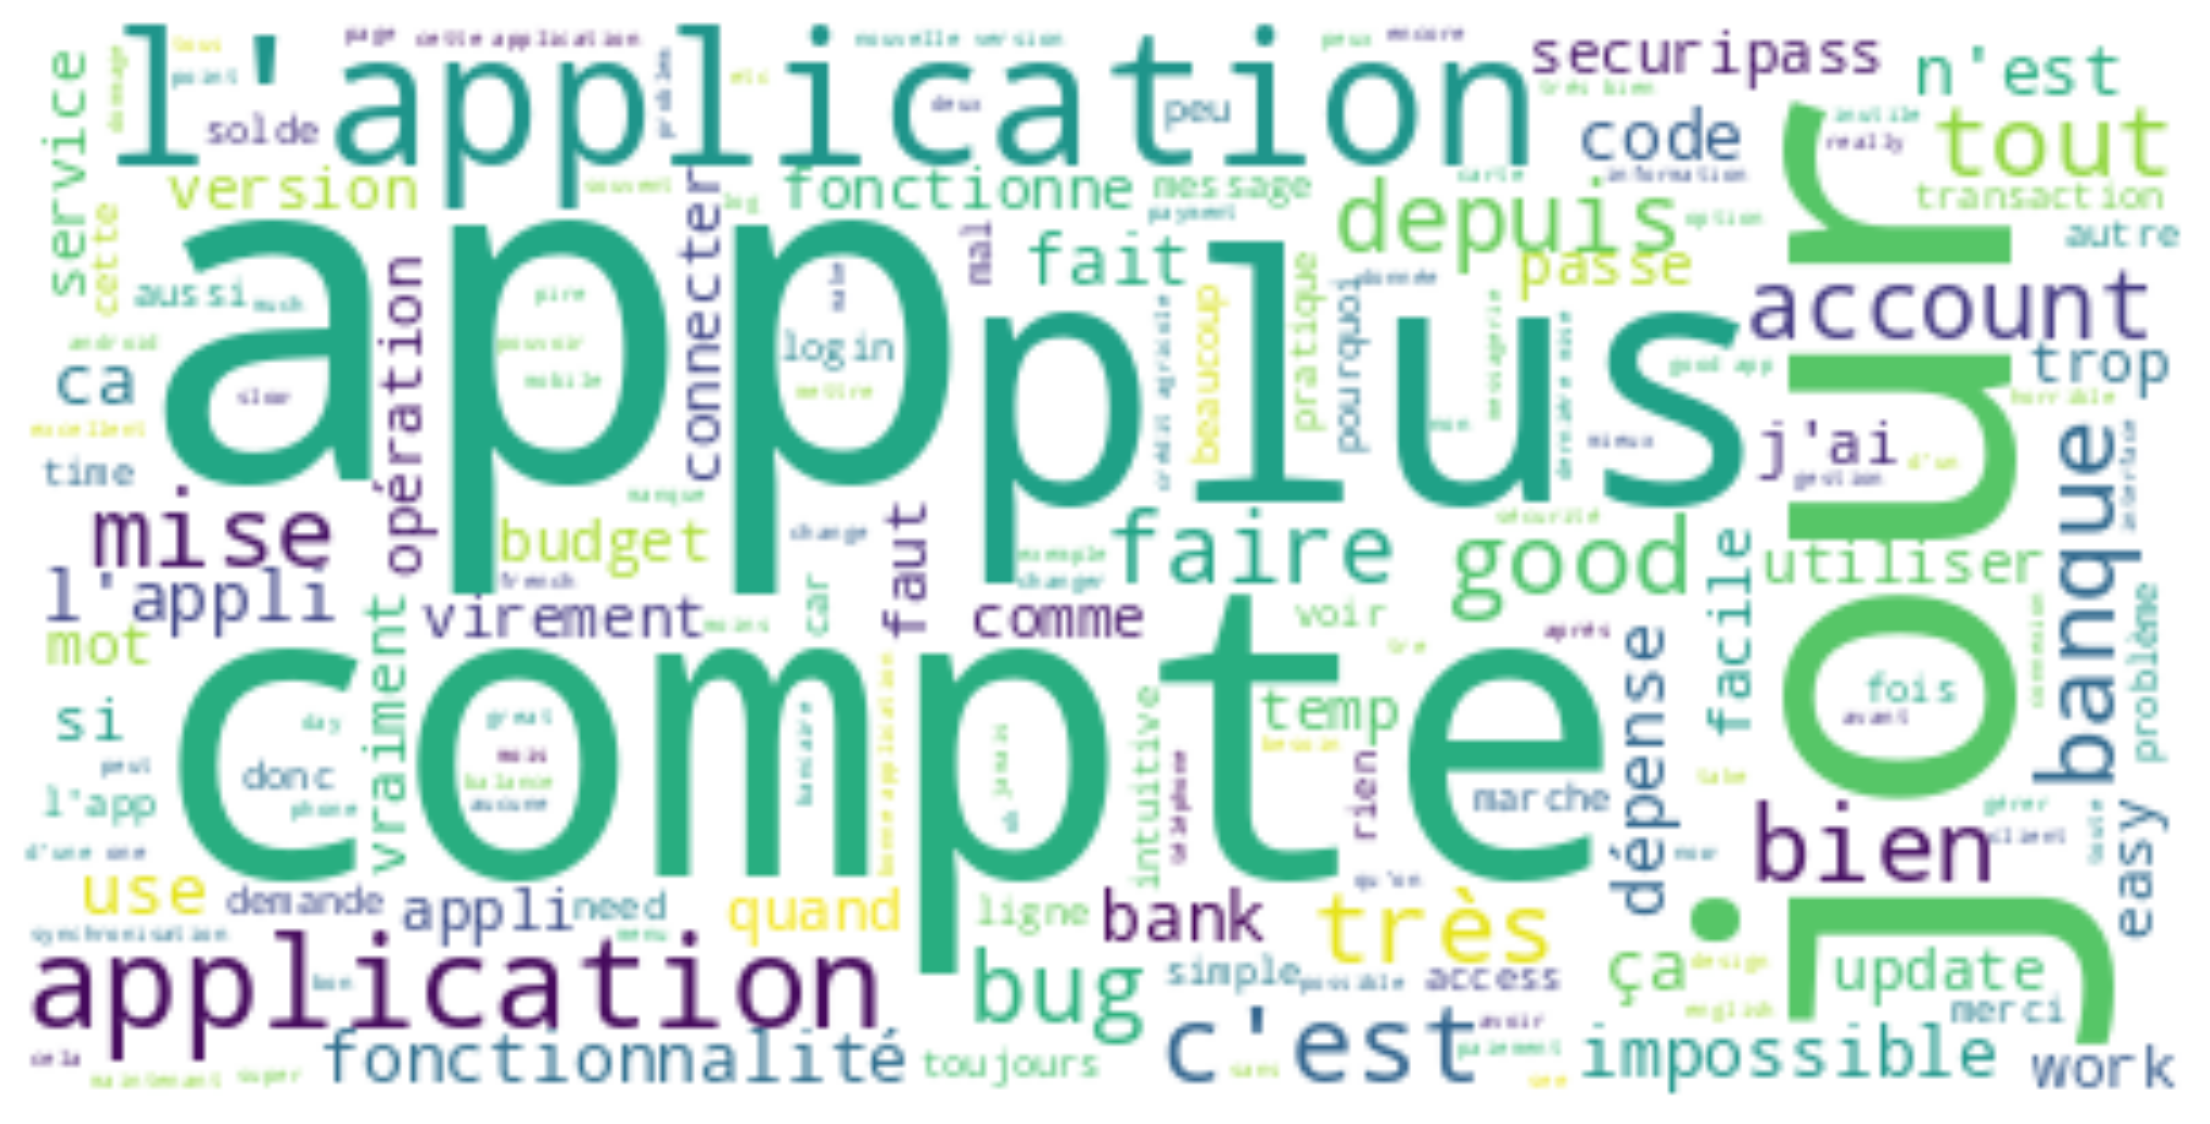

In [ ]:
STOPWORDS.add('plus') # add the words said to stopwords
STOPWORDS.add("c'est")
STOPWORDS.add("j'ai")
STOPWORDS.add('ça')
# re-generate the word cloud
cloud.generate(texte_combine)

# display the cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
!wget --quiet https://www.flaticon.com/fr/icone-gratuite/symbole-de-la-banque_2402
bank_mask = np.array(Image.open('2402.png'))
print('Image downloaded and saved!')

Image downloaded and saved!


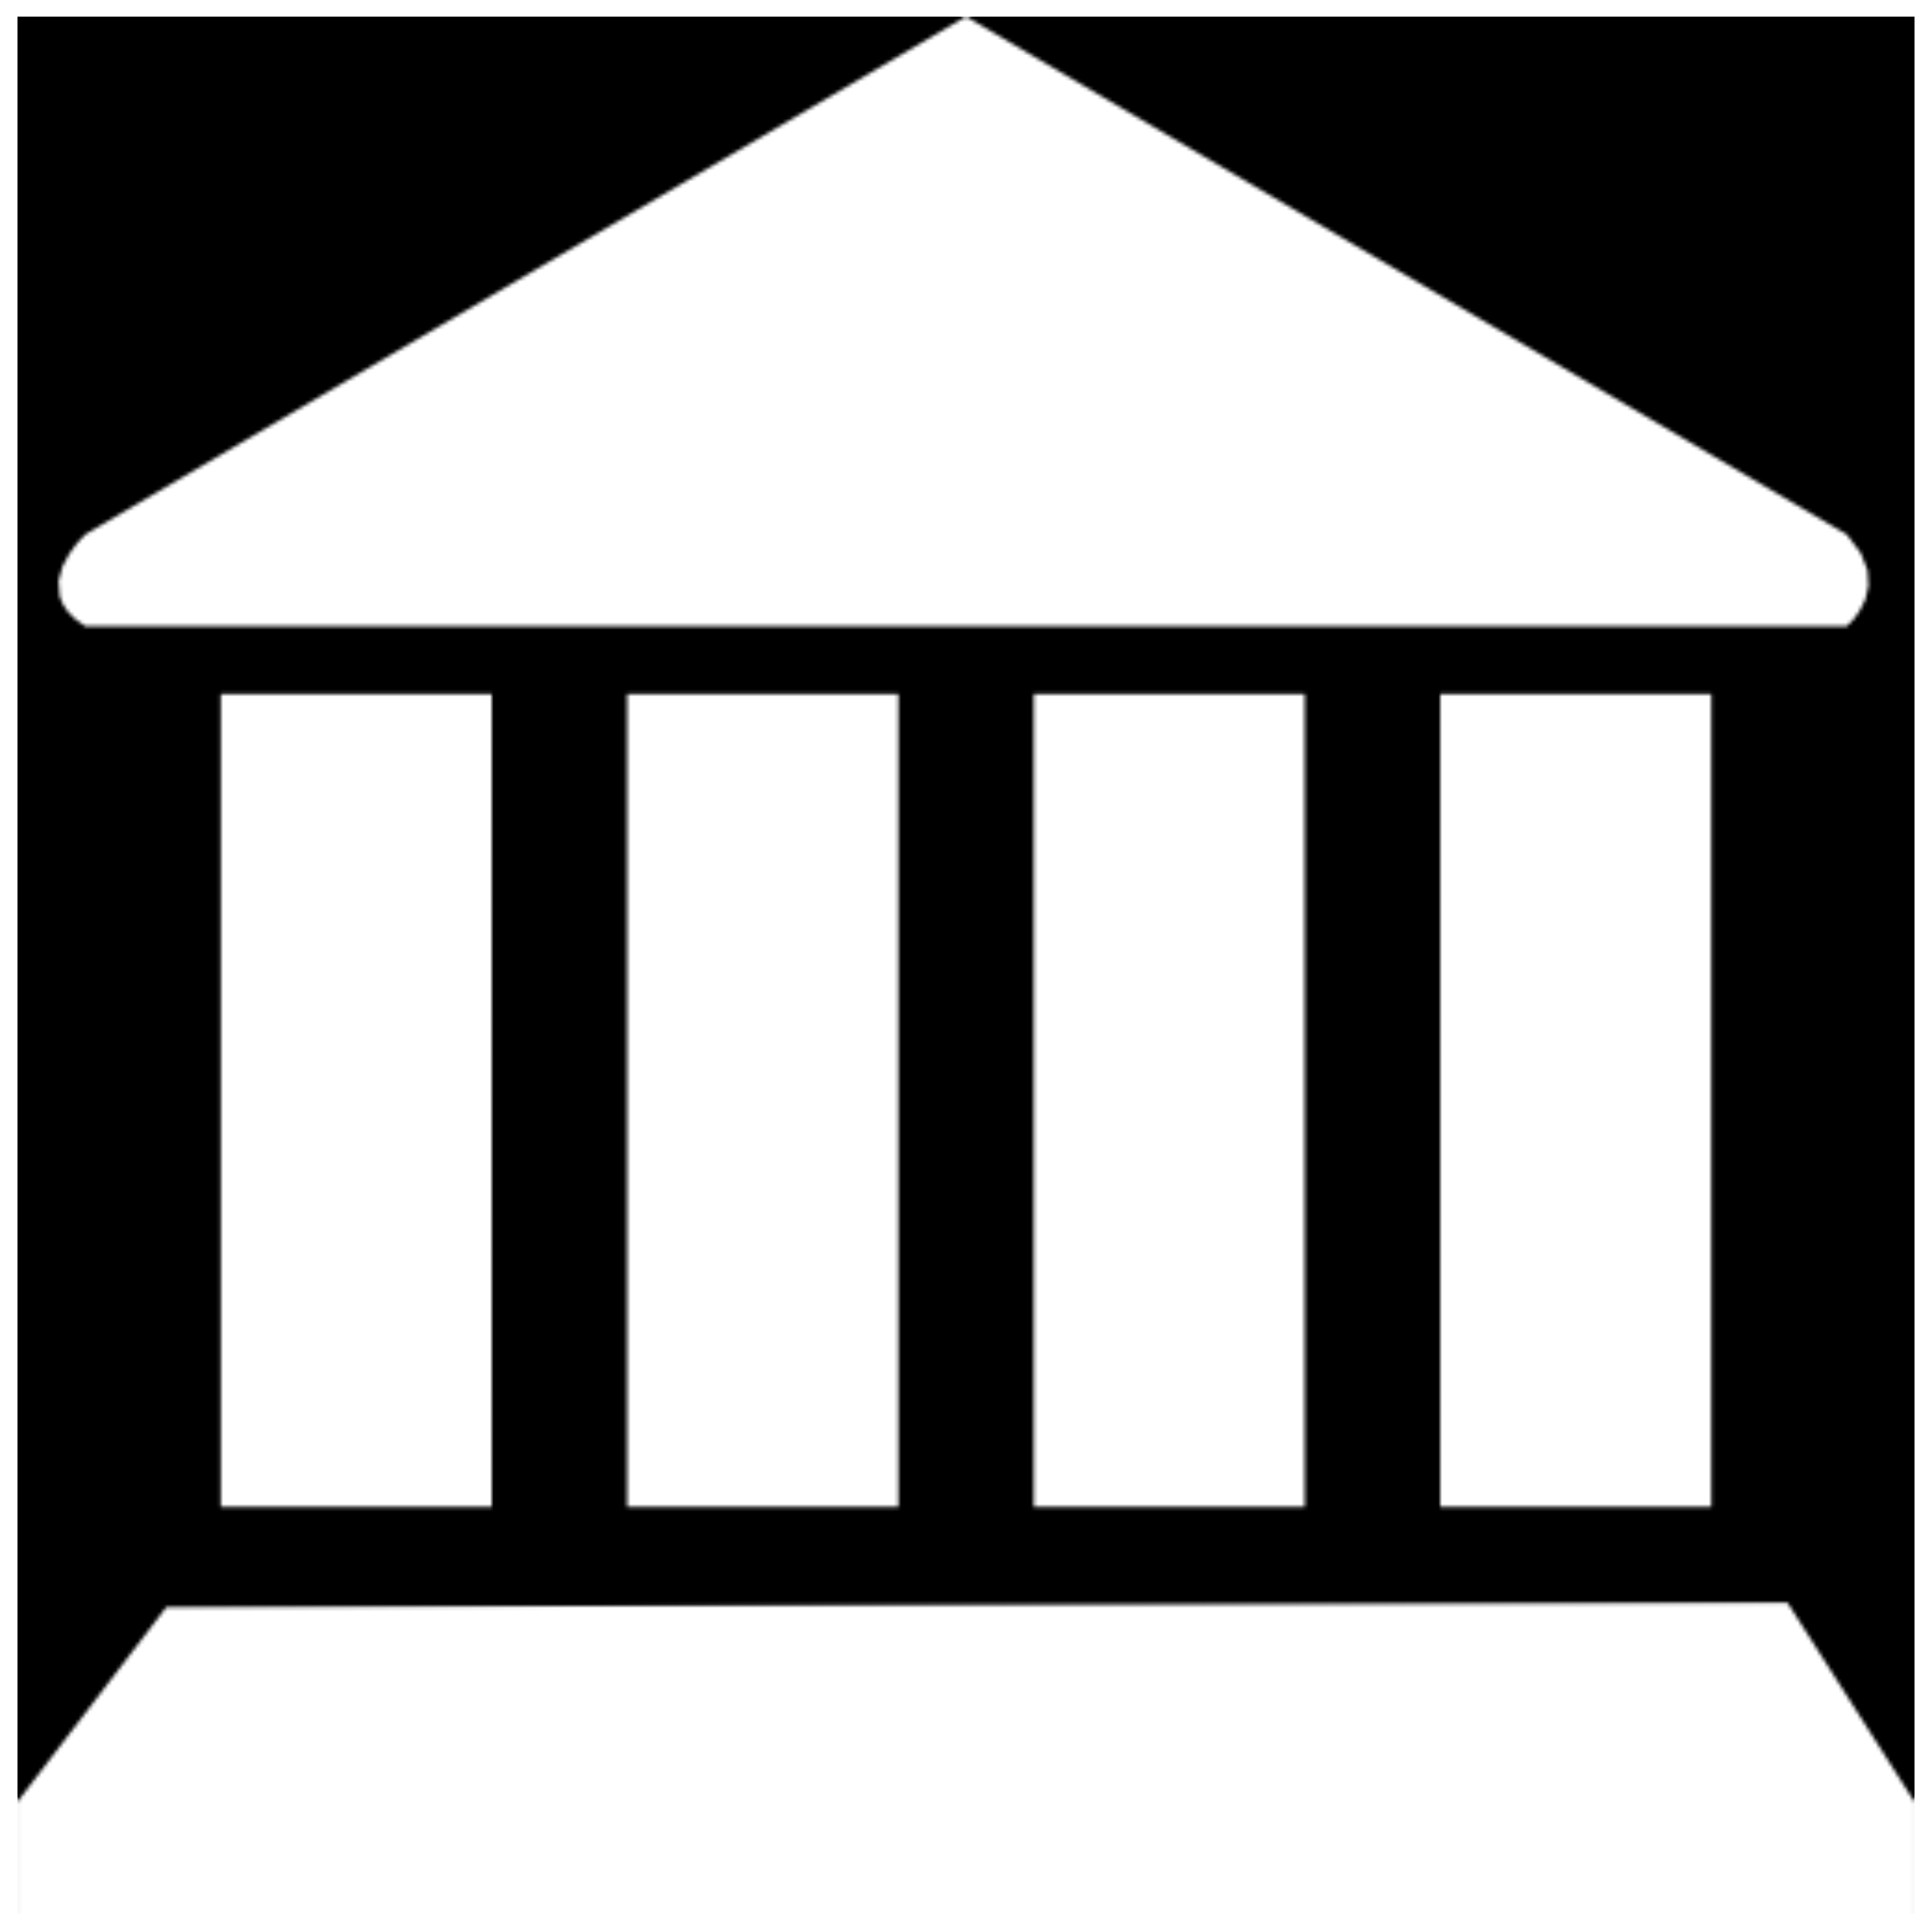

In [ ]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(bank_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

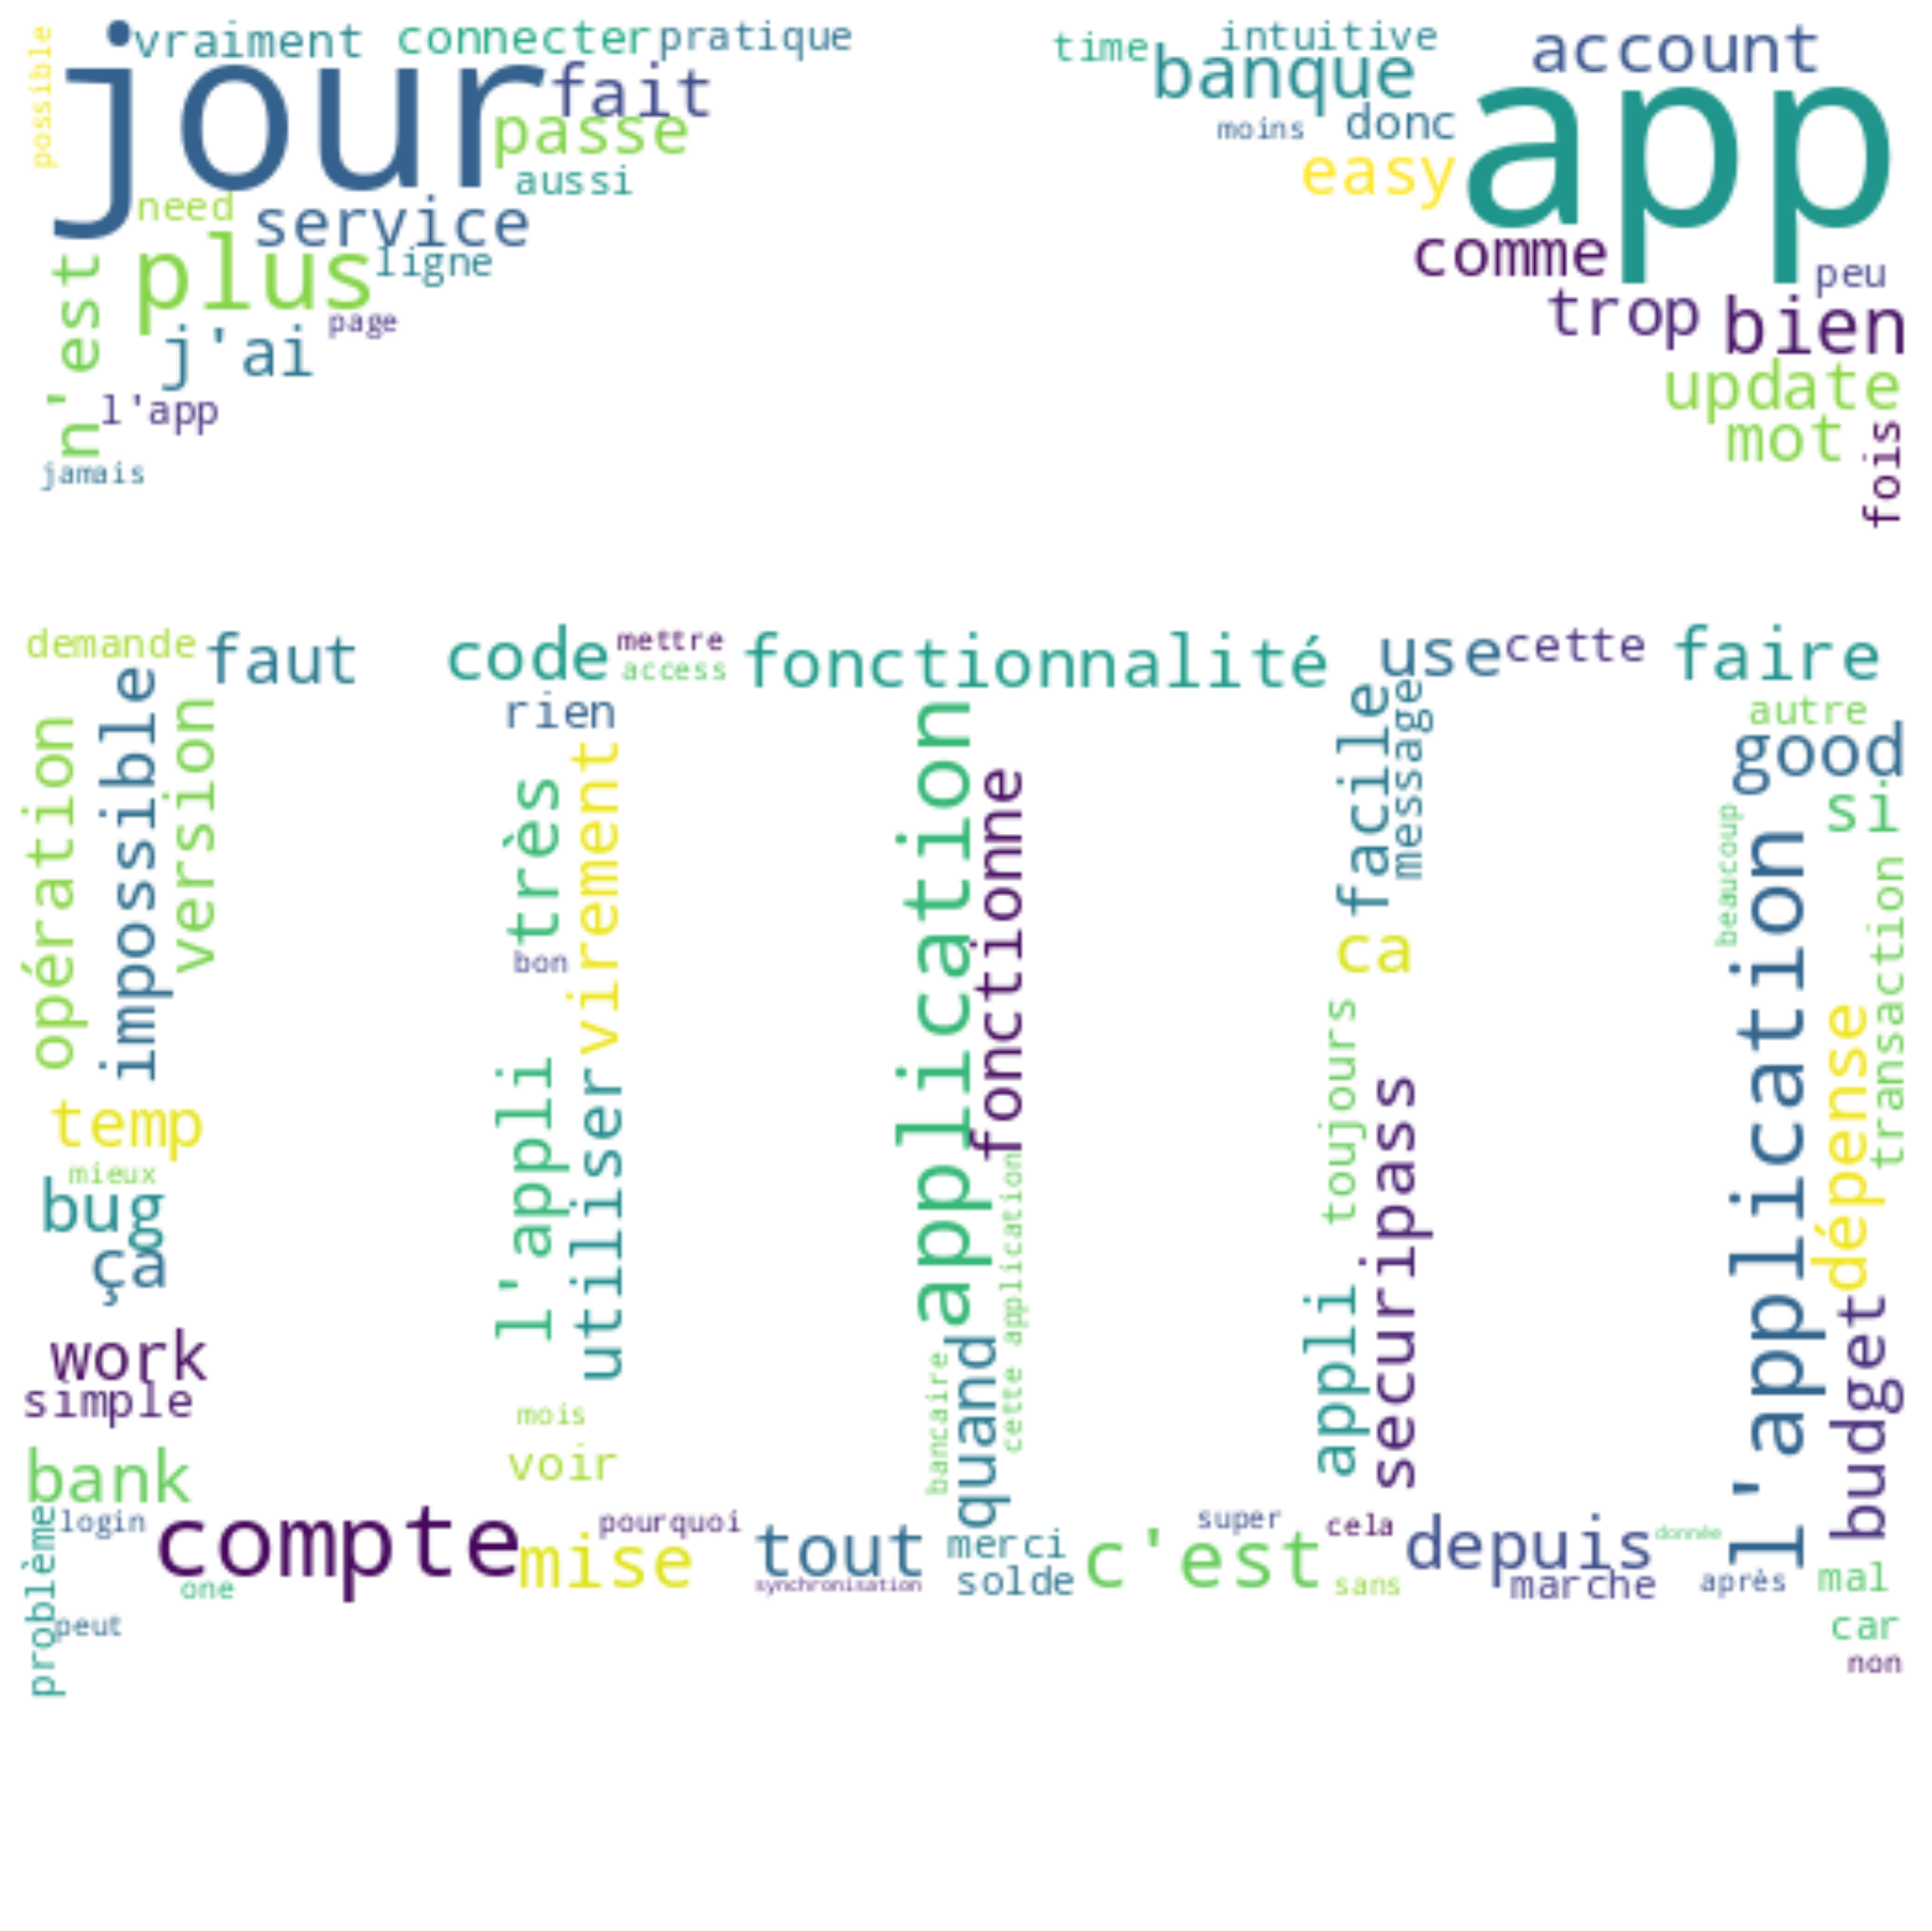

In [ ]:
# instantiate a word cloud object
cloud = WordCloud(background_color='white', max_words=100, mask=bank_mask, stopwords=_french )
STOPWORDS.add('plus') # add the words said to stopwords
STOPWORDS.add("c'est")
STOPWORDS.add("j'ai")
STOPWORDS.add('ça')
STOPWORDS.add('ca')
STOPWORDS.add('trop')
STOPWORDS.add('jamais')
STOPWORDS.add('bien')
STOPWORDS.add('comme')
STOPWORDS.add('quand')
STOPWORDS.add('rien')
STOPWORDS.add('faut')
STOPWORDS.add('cette')
STOPWORDS.add('aussi')
STOPWORDS.add('faire')
STOPWORDS.add('tout')
STOPWORDS.add('toute')
STOPWORDS.add('après')
STOPWORDS.add('car')
STOPWORDS.add('si')
STOPWORDS.add('toujours')
STOPWORDS.add('très')
STOPWORDS.add('donc')
STOPWORDS.add('peut')
STOPWORDS.add('peux')
STOPWORDS.add('peu')
STOPWORDS.add("l'application")
STOPWORDS.add("l'appli")
STOPWORDS.add('app')
STOPWORDS.add('application')
STOPWORDS.add('banque')
STOPWORDS.add('bank')
STOPWORDS.add('vraiment')
STOPWORDS.add('possible')
STOPWORDS.add('pourquoi')
STOPWORDS.add('cela')
STOPWORDS.add('bon')
STOPWORDS.add('encore')
STOPWORDS.add('good')
STOPWORDS.add('mieux')
STOPWORDS.add('simple')
STOPWORDS.add('facile')
STOPWORDS.add('super')
STOPWORDS.add('easy')
STOPWORDS.add('mettre')
STOPWORDS.add('autre')
STOPWORDS.add('voir')
STOPWORDS.add('merci')
STOPWORDS.add('depuis')
# generate the word cloud
cloud.generate(texte_combine)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Générer le nuage de mots
cloud.generate(texte_combine)

# Récupérer les 200 mots les plus fréquents
mots_frequents = list(cloud.words_.keys())[:200]

# Afficher les 200 premiers mots les plus fréquents
print(mots_frequents)

['app', 'jour', 'compte', 'plus', "l'application", 'application', "c'est", 'bien', 'mise', 'très', 'banque', 'good', 'tout', 'depuis', 'account', 'faire', 'bug', 'impossible', "l'appli", 'use', 'code', 'bank', 'fonctionnalité', "n'est", 'ça', 'ca', 'dépense', 'fait', 'securipass', 'budget', 'work', 'service', 'opération', 'update', 'easy', 'quand', 'faut', 'virement', 'fonctionne', "j'ai", 'comme', 'appli', 'passe', 'temp', 'utiliser', 'mot', 'si', 'version', 'trop', 'facile', 'connecter', 'vraiment', 'transaction', 'donc', 'toujours', 'fois', 'voir', 'message', 'rien', 'simple', 'cette', 'pratique', "l'app", 'time', 'mal', 'autre', 'intuitive', 'ligne', 'marche', 'aussi', 'car', 'need', 'demande', 'merci', 'problème', 'solde', 'peu', 'pourquoi', 'beaucoup', 'access', 'login', 'cette application', 'super', 'possible', 'sans', 'cela', 'après', 'bancaire', 'moins', 'mieux', 'jamais', 'peut', 'page', 'bon', 'mois', 'mettre', 'one', 'non', 'synchronisation', 'donnée']


In [ ]:
import nltk
nltk.download('punkt')  # Télécharger les données de tokenisation si vous ne les avez pas déjà

# Tokeniser le texte en phrases
phrases = nltk.sent_tokenize(texte_combine)

# Mot clé à rechercher
mot_cle = "good"

# Initialiser une liste pour stocker les phrases correspondantes
phrases_good = []

# Rechercher et stocker les phrases correspondantes
for phrase in phrases:
    if mot_cle in phrase:
        phrases_good.append(phrase)

# Afficher toutes les phrases correspondantes
for phrase in phrases_good:
    print(f"Phrase correspondante : {phrase}")

Phrase correspondante : ma banque is just stupid, always struggling to find the app cause i'm looking for an app starting with c. good job anyway.
Phrase correspondante : bah enfaite laissez nous utiliser l'app avec un tel rooté service momentanément inaccessible depuis dernière màj…  comme beaucoup de monde… having used my card for several payments recently,, the app is not updating to reflect this, so not good to keep track of things.
Phrase correspondante : good application i love it either too slow or frozen...which may generate some big issues.
Phrase correspondante : the old version was better than the current one, not easy to use, the color is not good, i don't know why they updated to something not working properly and so ugly.
Phrase correspondante : énervant plus du tout utile depuis la dernière version de l'interface very good up really bad experience since last update unable to access need to log in my securipass to access but need to be log in to access my securipass.... r

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Tokeniser le texte en phrases
phrases = nltk.sent_tokenize(texte_combine)

# Mot clé à rechercher
mot_cle = "bug"

# Initialiser une liste pour stocker les phrases correspondantes
phrases_bug = []

# Rechercher et stocker les phrases bug
for phrase in phrases:
    if mot_cle in phrase:
        phrases_bug.append(phrase)

# Afficher toutes les phrases bug
for phrase in phrases_bug:
    print(f"Phrase correspondante : {phrase}")

Phrase correspondante : bug: impossible d'uploader une pièce jointe dans mon espace de messagerie sécurisée horrible !
Phrase correspondante : vous pourriez enlever une ou deux étapes (facilement) pour nous faciliter la vie compliqué et buggy.
Phrase correspondante : maintenant l'appli est jolie et pratique, donc 5 étoiles, merci les devs pour la réactivité de quelques mois 😬 bien, mais bug.
Phrase correspondante : 1 fois sur 2 c'est impossible de se connecter et l'autre fois sur 2 ça bug une fois connecté.
Phrase correspondante : impossible de se connecter, l'appli bug et tourne en rond lorsqu'il faut mettre ses identifiants (veuillez vous connecter, je me connecte, retour à veuillez vous connecter) bloody useless la mise à jour de l'application prive cette dernière de plusieurs fonctionnalités comme, la visualisation des répartitions des dépenses mensuel.
Phrase correspondante : énervant plus du tout utile depuis la dernière version de l'interface very good up really bad experience s

# IV LDA du Crédit Agricole sur les avis positifs de 2020

# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
# Avis positifs 2020 CA
dfCA2020_Positif = df.loc[(df['sentiment2'] == 'positive') & (df['année'] == 2020), : ]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dfCA2020_Positif.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


reviewId                 userName  \
52  4c3a3b1e-58ff-468c-be35-7b9b6cb7d795  Voyeurisme Contemporain   
55  b78b5fad-dbbf-4d0f-8d8c-024be710d592          Alexis Bouzigon   
57  c30652ed-315e-44f9-b934-2b6fc4bb660a                  unniteq   
60  bb77cdd9-d4bf-48ad-a668-50ff76661129                    Bob K   
64  f224fcae-7db0-4856-b2af-5acbc6b6fbb9                     Rémy   

                                            userImage  \
52  https://play-lh.googleusercontent.com/a-/ALV-U...   
55  https://play-lh.googleusercontent.com/a-/ALV-U...   
57  https://play-lh.googleusercontent.com/a-/ALV-U...   
60  https://play-lh.googleusercontent.com/a/ACg8oc...   
64  https://play-lh.googleusercontent.com/a/ACg8oc...   

                                              content  score  thumbsUpCount  \
52  Je ne vois pas ce qui me retiens de quitter ce...      1              0   
55  Application qui ne fonctionne jamais. C'est ho...      1              0   
57  Manque d'énormément de fonctionnalités par rap...      1              5   
60  Horrible service, horrible application, horrib...      1              0   
64  La derniere version est une regression. On ne ...      1              0   

   reviewCreatedVersion                  at replyContent repliedAt appVersion  \
52               31.0.0 2022-12-26 01:17:19         None       NaT     31.0.0   
55               31.0.0 2022-12-12 13:50:06         None       NaT     31.0.0   
57               31.0.0 2022-12-07 13:08:25         None       NaT     31.0.0   
60               31.0.0 2022-12-02 12:01:16         None       NaT     31.0.0   
64               30.4.0 2022-11-30 11:46:50         None       NaT     30.4.0   

    ID                date  année  sentiment sentiment2  
52  53 2022-12-26 01:17:19   2022          0   negative  
55  56 2022-12-12 13:50:06   2022          0   negative  
57  58 2022-12-07 13:08:25   2022          0   negative  
60  61 2022-12-02 12:01:16   2022          0   negative  
64  65 2022-11-30 11:46:50   2022          0   negative

In [ ]:
text1 = dfCA2020_Positif['content'].tolist()
text1 = [item for item in text1 if item is not None]
texte1 = " ".join(text1)
print(text1)

["Je ne vois pas ce qui me retiens de quitter cette banque, entre leur application qui n'est même pas fichu d'exécuter les fonctions de base : ouverture de l'application, ouvrir le sécuripass lors d'un achat en ligne et effectuer des virement hors France, l'historique des virements n'est même pas instantané en 2023... Une banque old school qui ne peut rassasier que des quinquagénaires, pour moi c'est ciao bello", "Application qui ne fonctionne jamais. C'est honteux ! 1 fois sur 2 c'est impossible de se connecter et l'autre fois sur 2 ça bug une fois connecté. Du coup on ne peut jamais payer avec le securipass (seule fonctionnalité intéressante de toute façon)", 'Manque d\'énormément de fonctionnalités par rapport au site web ou même à l\'ancienne version de l\'appli. L\'UX est aussi moins bonne que le site. Lorsqu\'un virement échoue, un message d\'erreur générique apparaît (du genre "quelque chose s\'est mal passé"). Il faut réessayer via le site pour avoir la raison de l\'échec. Pour

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import nltk
nltk.download('punkt')  # Télécharger les données de tokenisation si vous ne les avez pas déjà

# Tokeniser le texte en phrases
phrases = nltk.sent_tokenize(texte1)

# Mot clé à rechercher
mot_cle = "Zambia" #pratique

# Initialiser une liste pour stocker les phrases correspondantes
phrases_good = []

# Rechercher et stocker les phrases correspondantes
for phrase in phrases:
    if mot_cle in phrase:
        phrases_good.append(phrase)

# Afficher toutes les phrases correspondantes
for phrase in phrases_good:
    print(f"Phrase correspondante : {phrase}")

Phrase correspondante : I live in Zambia and have an online account as a non french citizen and since i got back to Zambia about 6 weeks ago I've been locked out of my account and cannot get access to it.
Phrase correspondante : I've put my Zambian phone number as the number of choice to receive my security code to login to my account but whenever i request the security code through the app i never receive it and it has been weeks of having this problem.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Tokeniser le texte en phrases
phrases = nltk.sent_tokenize(texte_combine)

# Mot clé à rechercher
mot_cle = "bug"

# Initialiser une liste pour stocker les phrases correspondantes
phrases_bug = []

# Rechercher et stocker les phrases bug
for phrase in phrases:
    if mot_cle in phrase:
        phrases_bug.append(phrase)

# Afficher toutes les phrases bug
for phrase in phrases_bug:
    print(f"Phrase correspondante : {phrase}")

In [ ]:
# Nombre de commentaires positifs et négatifs du CA en 2020 et 2022 selon le modèle BERT
#dfCA2020 = df.loc[(df['année'] == 2020), : ]
dfCA2022 = df.loc[(df['année'] == 2022), : ]
#dfCA2020.head()
dfCA2022.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


reviewId                 userName  \
52  4c3a3b1e-58ff-468c-be35-7b9b6cb7d795  Voyeurisme Contemporain   
53  dff44031-0521-4dc0-80c1-79ed0245cf55            Thibaut Liger   
54  2ba8cc50-4ece-494d-9889-395f73c4a99b         Ethan TEBERREROU   
55  b78b5fad-dbbf-4d0f-8d8c-024be710d592          Alexis Bouzigon   
56  24b43633-b85e-4c56-985e-f859a5e9fb06                  Marc G.   

                                            userImage  \
52  https://play-lh.googleusercontent.com/a-/ALV-U...   
53  https://play-lh.googleusercontent.com/a-/ALV-U...   
54  https://play-lh.googleusercontent.com/a-/ALV-U...   
55  https://play-lh.googleusercontent.com/a-/ALV-U...   
56  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                              content  score  thumbsUpCount  \
52  Je ne vois pas ce qui me retiens de quitter ce...      1              0   
53  C'est le retour de la catégorisation des opéra...      5              5   
54                                    Bien, mais bug.      3              0   
55  Application qui ne fonctionne jamais. C'est ho...      1              0   
56  Still need some improvement. Where do I set th...      3              1   

   reviewCreatedVersion                  at replyContent repliedAt appVersion  \
52               31.0.0 2022-12-26 01:17:19         None       NaT     31.0.0   
53               31.0.0 2022-12-20 11:04:34         None       NaT     31.0.0   
54                 None 2022-12-16 11:26:54         None       NaT       None   
55               31.0.0 2022-12-12 13:50:06         None       NaT     31.0.0   
56               31.0.0 2022-12-09 17:43:16         None       NaT     31.0.0   

    ID                date  année  sentiment sentiment2  
52  53 2022-12-26 01:17:19   2022          0   negative  
53  54 2022-12-20 11:04:34   2022          2   positive  
54  55 2022-12-16 11:26:54   2022          1    neutral  
55  56 2022-12-12 13:50:06   2022          0   negative  
56  57 2022-12-09 17:43:16   2022          1    neutral

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


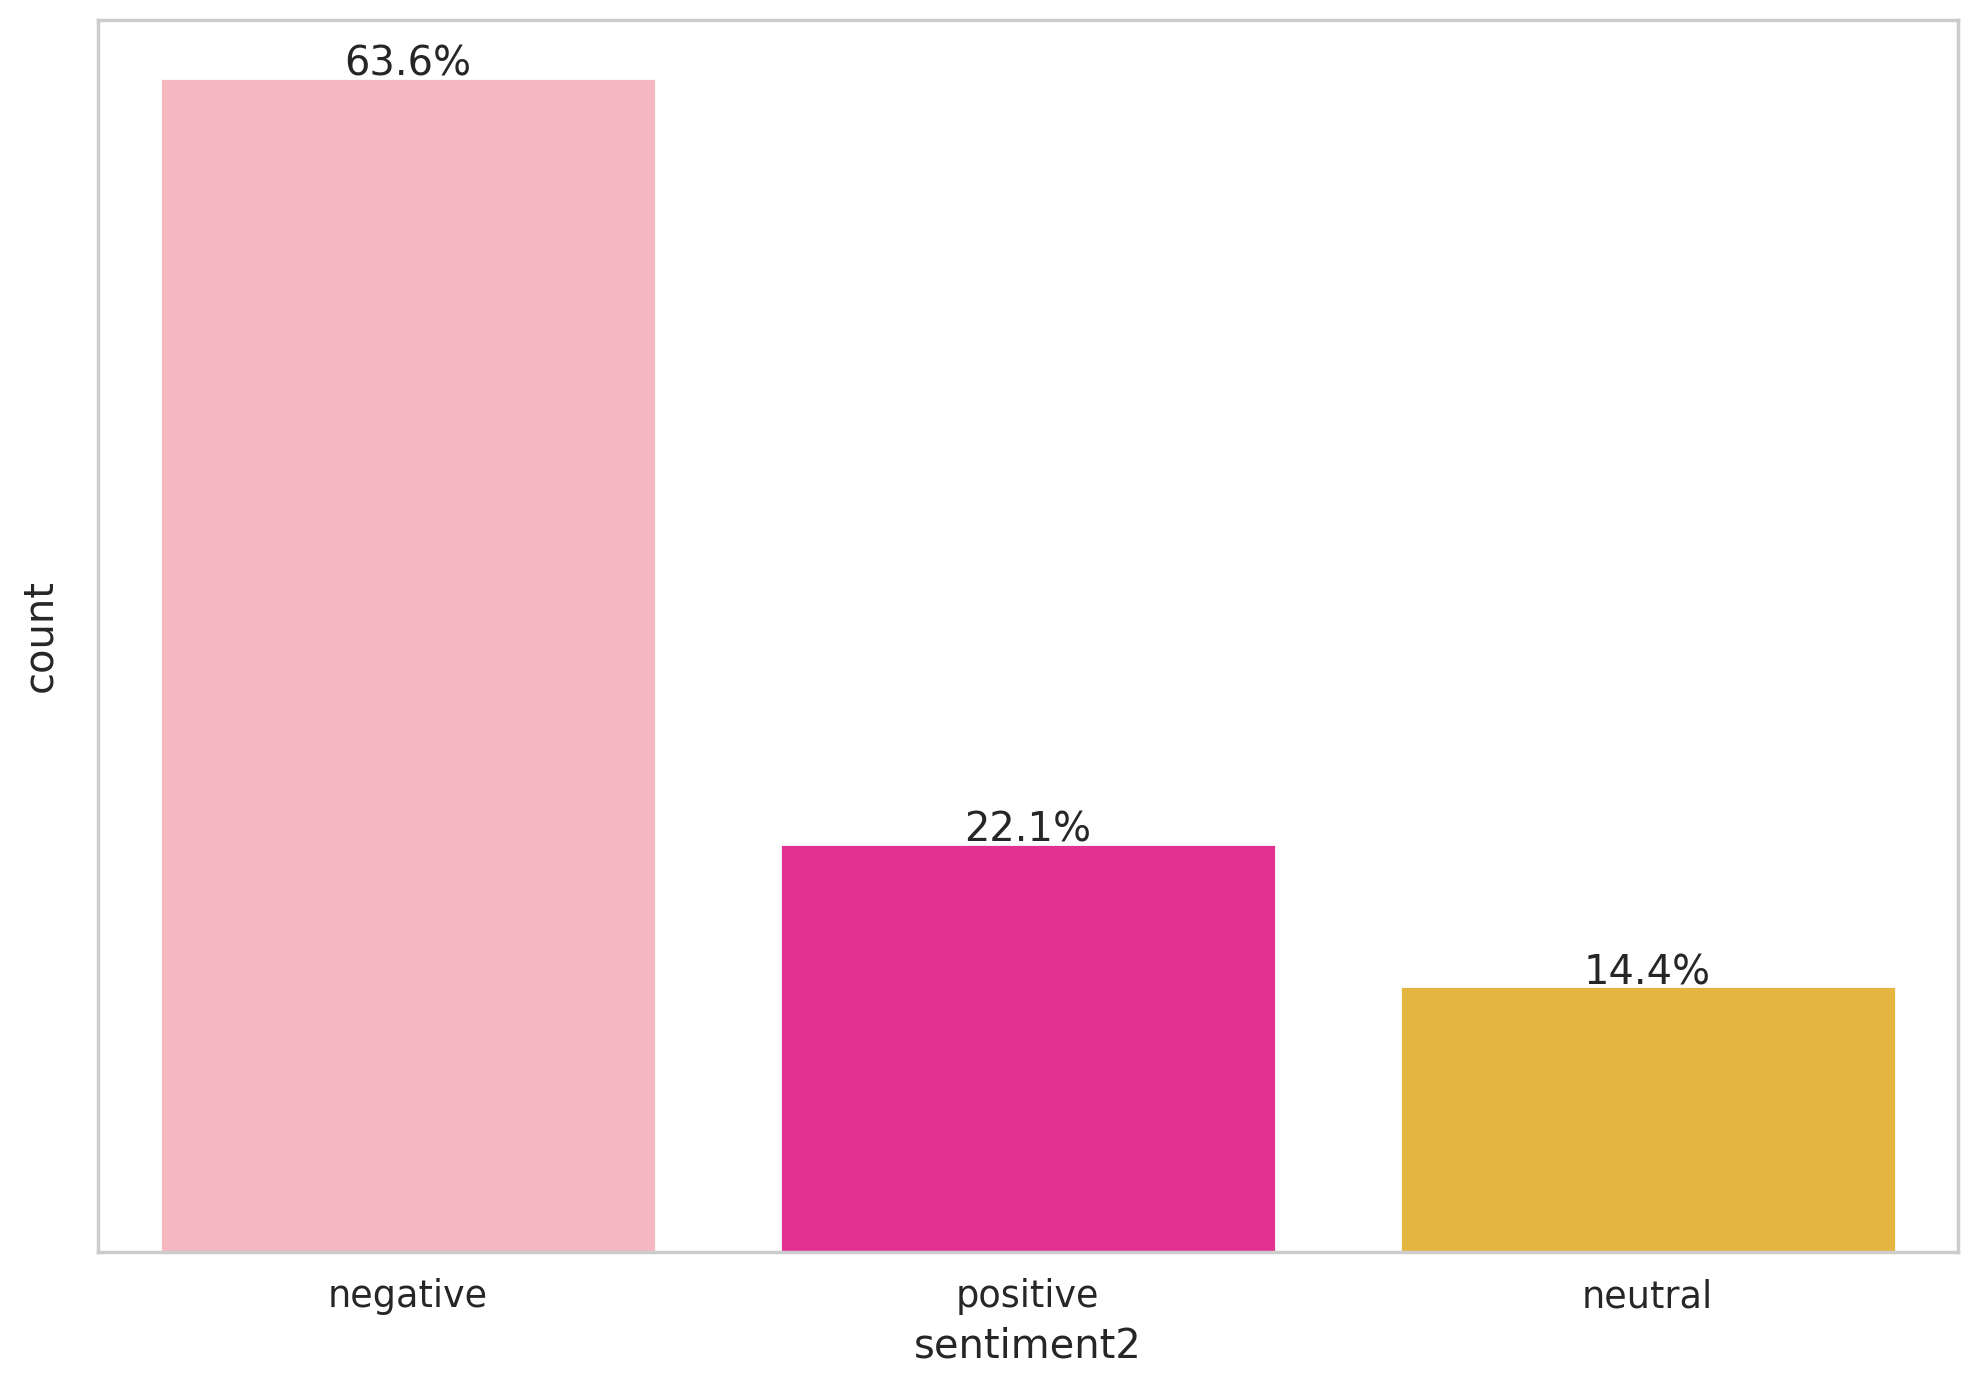

In [ ]:
# Visualisation du nombre de commentaires positifs et négatifs du CA en 2020 et 2022 selon le modèle BERT
#ax = sns.countplot(data=dfCA2020, x='sentiment2')
ax = sns.countplot(data=dfCA2022, x='sentiment2')
ax.set_yticklabels([])

# Calculez les pourcentages pour chaque catégorie
#total = len(dfCA2020)
total = len(dfCA2022)
for p in ax.patches:
    height = p.get_height()
    percentage = height / total * 100
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.grid(False)
plt.show()

In [ ]:
# Supprimer la ponctuation
dfCA2020_Positif['content'] = dfCA2020_Positif['content'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convertir en minuscules
dfCA2020_Positif['content'] = dfCA2020_Positif['content'].map(lambda x: x.lower())
dfCA2020_Positif['content'].head()

In [ ]:
# Tokeniser  = Regroupons chaque phrase en une liste de mots
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = dfCA2020_Positif.content.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

In [ ]:
# bigramme/trigramme = Les bigrammes sont deux mots qui apparaissent fréquemment ensemble dans le document. Les trigrammes sont 3 mots fréquents
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
#Supprimez les mots vides, créer des bigrammes et lemmatiser
# NLTK Stop words
stop_words = stopwords.words('french')
stop_words.extend(["c'est", "j'ai", 'ça', 'ca', 'trop','jamais','bien','comme','quand','rien','faut','cette','tout',
'toute','après','car','si','toujours','très','donc','peut','peux','peu',"l'application","l'appli",'app','application',
'banque','bank','vraiment','possible','pourquoi','cela','bon','encore','good','mieux','simple','facile','super'])


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30]) # nb apres la virgule indique combien de fois le mot apparait dans le corpus

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
#Vous pouvez voir les mots-clés pour chaque sujet et le poids (importance) de chaque mot-clé en utilisant lda_model.print_topics()\

In [ ]:
# Calculer le score de perplexité et de cohérence du modèle

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

    return coherence_model_lda.get_coherence()

Nombre de sujets (K)
Hyperparamètre de Dirichlet alpha : densité de document-sujet
Hyperparamètre de Dirichlet bêta : densité de mots-sujets

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word,
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)

In [ ]:
# Récupération du fichier Excel contenant les paramètres pour une meilleure optimisation du modèle
pd.DataFrame(model_results).to_csv('CA2020Positif.csv', index=False)
pbar.close()

 Déterminer le nombre optimal de sujets. Le graphique ci-dessous présente le score de cohérence, C_v, pour le nombre de sujets répartis dans deux ensembles de validation

In [ ]:
# Entraînement du modèle optimisé (changer les paramètres en fonction de la meilleure valeur de cohérence)
num_topics = 8

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state= 100 ,
                                           chunksize= 100 ,
                                           passes= 10 ,
                                           alpha=  "asymmetric",
                                           eta= 0.909999 )

In [ ]:
# Visualize the topics
!pip install "pandas<2.0.0"
pyLDAvis.enable_notebook()
os.mkdir("./results")

LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)#

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared